In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from torch_geometric.utils import *
from torch_geometric.data import Data
import torch
import random
import numpy as np
random.seed()
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import GNNExplainer
import networkx as nx
import pandas as pd

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


Make Synthetic Dataset 1 Cycle

In [3]:
def get_label(X, E, k_1, k_2):
    '''
    X: Node Feature Set
    E: Edge Index
    k_1: Const. for s(x)
    k_2: Const. for n(x)
    '''
    Ft_Sum = torch.sum(X,dim=1,keepdim=True)
    S = torch.exp(Ft_Sum - k_1)
    N = torch.exp(Ft_Sum - k_2)
    A = to_dense_adj(E)
    A = A.squeeze()
    N = torch.matmul(A, N)
    F = S + N
    P = 1/(1+F)
    Y = torch.bernoulli(P)
    # Y = Y.long()
    return Y, P

In [4]:
# of Nodes
V = 2000
train_index = int(V*0.7)
val_index = int(V*0.7)+int(V*0.15)

In [5]:
N1 = torch.normal(mean=2, std=1.0,size = (V,3))
N2 = torch.normal(mean=-2, std=1.0,size = (V,3))
Prob = torch.rand(V,3)
X = torch.where(Prob>0.5, N1, N2)

In [6]:
## Generate Synthetic Dataset
#edge list
G = nx.generators.classic.cycle_graph(V)
data = from_networkx(G)

#transform features into an exponent of them
Exp_X = torch.exp(X)
#unimportant features
Extension = torch.exp(torch.normal(mean=0.0, std=1.0,size=(V,2)))
data.x = torch.cat((Exp_X, Extension), 1)
#label
Y,P = get_label(X, data.edge_index, 3, 3)
data.y = Y
# train val test mask
train = torch.zeros(V, dtype=torch.bool)
val = torch.zeros(V, dtype=torch.bool)
test = torch.zeros(V, dtype=torch.bool)
train[:train_index] = True
val[train_index:val_index] = True
test[val_index:] = True
data.train_mask = train
data.val_mask = val
data.test_mask = test

In [12]:
data_x = pd.DataFrame(data.x)
data_x.to_csv('./Synthetic_Data/Data1/data_x')
data_edge_index = pd.DataFrame(data.edge_index)
data_edge_index.to_csv('./Synthetic_Data/Data1/data_edge_index')
data_y = pd.DataFrame(data.y)
data_y.to_csv('./Synthetic_Data/Data1/data_y')
data_P = pd.DataFrame(P)
data_P.to_csv('./Synthetic_Data/Data1/bernoulli_prob')
data_train_mask = pd.DataFrame(data.train_mask)
data_train_mask.to_csv('./Synthetic_Data/Data1/data_train_mask')
data_val_mask = pd.DataFrame(data.val_mask)
data_val_mask.to_csv('./Synthetic_Data/Data1/data_val_mask')
data_test_mask = pd.DataFrame(data.test_mask)
data_test_mask.to_csv('./Synthetic_Data/Data1/data_test_mask')

tensor(837.)
tensor(1163.)


<BarContainer object of 2 artists>

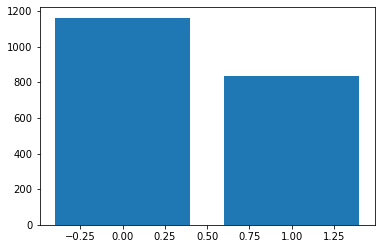

In [13]:
#label distribution
ones = Y.sum()
print(ones)
zeros = V - ones
print(zeros)
plt.bar([0,1],[zeros,ones])

In [14]:
## Optimal Prediction
pred = torch.round(P)  # Use the class with highest probability.
correct = pred == data.y  # Check against ground-truth labels.
# print(correct.sum())
val_acc = int(correct.sum())/V  # Derive ratio of correct predictions.
print(val_acc)

0.84


In [15]:
data.to(device)

Data(edge_index=[2, 4000], num_nodes=2000, x=[2000, 5], y=[2000, 1], train_mask=[2000], val_mask=[2000], test_mask=[2000])

In [16]:
#Testing True Data Distribution with Dataset that has unimportant features masked with 0
test_eval_x = torch.cat((Exp_X, torch.zeros(V,2)),1)
test_eval_data = from_networkx(G)
test_eval_data.x = test_eval_x
test_eval_data.y = Y
test_eval_data.test_mask = test
test_eval_data.to(device)

Data(edge_index=[2, 4000], num_nodes=2000, x=[2000, 5], y=[2000, 1], test_mask=[2000])

Models

In [17]:
@torch.no_grad()
def Create_Samples(X, E, mask, p_1=0.5, p_2=0.5):
    '''
    Create a dataset for samples
    X: Node Features
    E: Edge Index
    mask: the mask token to be used
    p_1: the bernoulli prob. of masking for adjacency matrix
    p_2: the bernoulli prob. of masking for features
    '''
    # Number of Nodes
    V = X.size()[0] 
    # Number of Features
    F = X.size()[1]

    ## sampling random adjacency matrix
    #Original Adj Matrix
    A = to_dense_adj(E)
    #Prob of Keeping Adj Matrix
    P_adj = torch.rand(1,V,V).to(device)
    C = torch.mul(A,P_adj)
    #n stacks of Sample Adj Matrix
    Sample_Adj = C > p_1
    Sample_Adj,_ = dense_to_sparse(Sample_Adj)
    
    ## sampling random features
    P_feature = torch.rand(1,F).to(device)
    # Mask_feature = mask*torch.ones(1,F,dtype=torch.double).to(device)
    mask = torch.as_tensor(mask, dtype=torch.float).to(device)
    # mask = mask.double()
    # print(mask)
    # prob = torch.as_tensor(1-p_2, dtype=torch.double).to(device)
    # prob = (1-p_2)*torch.ones(1,F,dtype=torch.double).to(device)
    SF = torch.where(P_feature>(1-p_2),mask,X.float())
    Sample_Ft = SF
    
    return Sample_Ft, Sample_Adj

In [18]:
class Model(torch.nn.Module):
    def __init__(self, num_features, mask=-0.1, p_1=0, p_2=0):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(num_features, 16)
        self.bn1 = nn.BatchNorm1d(16)
        self.conv1 = GCNConv(16, 16)
        self.fc2 = nn.Linear(16, 16)
        self.bn2 = nn.BatchNorm1d(16)
        self.fc3 = nn.Linear(16,1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.mask = False
        self.mask_param = [mask, p_1, p_2]

    def forward(self, x, edge_index):
        if self.mask == False:
            E = edge_index
            X = x
            self.mask = True
        else:
            X, E = Create_Samples(x, edge_index, self.mask_param[0], self.mask_param[1], self.mask_param[2])
        x = self.fc1(X)
        x = self.relu(x)
        x = self.bn1(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv1(x, E)
        x = self.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.bn2(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.fc3(x)
        x = self.sigmoid(x)
        return x
    
    def change_param(self, mask, p_1, p_2):
        self.mask_param = [mask,p_1,p_2]

    def mask_off(self):
        self.mask = False
        
model = Model(num_features=5, mask=0, p_1 = 0, p_2=0)
print(model)

Model(
  (fc1): Linear(in_features=5, out_features=16, bias=True)
  (bn1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1): GCNConv(16, 16)
  (fc2): Linear(in_features=16, out_features=16, bias=True)
  (bn2): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=16, out_features=1, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)


In [19]:
@torch.no_grad()
def validate(model):
    model.eval()
    model.mask_off()
    out = model(data.x, data.edge_index)
    val_loss = criterion(out[data.val_mask], data.y[data.val_mask])
    pred = torch.round(out)  # Use the class with highest probability.
    val_correct = pred[data.val_mask] == data.y[data.val_mask]  # Check against ground-truth labels.
    val_acc = int(val_correct.sum()) / int(data.val_mask.sum())  # Derive ratio of correct predictions.
    return val_loss, val_acc

@torch.no_grad()
def test(model):
    model.eval()
    model.mask_off()
    out = model(data.x, data.edge_index)
    pred = torch.round(out) # Use the class with highest probability.
    test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
    test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
    return test_acc

@torch.no_grad()
def test_eval(model):
    model.eval()
    model.mask_off()
    out = model(test_eval_data.x, test_eval_data.edge_index)
    pred = torch.round(out) # Use the class with highest probability.
    test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
    test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
    return test_acc

In [20]:
from IPython.display import clear_output
@torch.no_grad()
def live_plot(data_dict, figsize=(7,5), title=''):
    clear_output(wait=True)
    for label,data in data_dict.items():
        plt.plot(data, label=label)
    plt.title(title)
    plt.grid(True)
    plt.xlabel('epoch')
    plt.legend(loc='upper right') # the plot evolves to the right
    plt.show()

In [21]:
@torch.no_grad()
def save_plot(data_dict, figsize=(7,5), title=''):
    for label,data in data_dict.items():
        plt.plot(data, label=label)
    plt.title(title)
    plt.grid(True)
    plt.xlabel('epoch')
    plt.legend(loc='upper right') # the plot evolves to the right
    plt.savefig(f'{title}.png')

Model Trained on the Full Feature Set

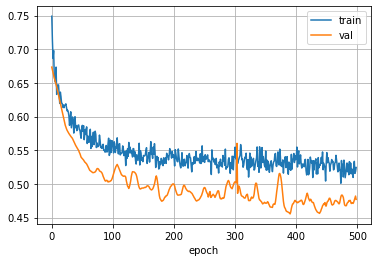

Val Accuracy: 0.7667
best model taken from epoch: 391


In [65]:
model = Model(num_features=5, mask=0, p_1 = 0, p_2=0)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.BCELoss()

def train(epoch):
    model.train()
    optimizer.zero_grad()  # Clear gradients.
    out = model(data.x, data.edge_index)  # Perform a single forward pass.
    loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    return loss

losses = {'train':[], 'val': []}

best_loss = 100
final_epoch = 0
for epoch in range(1, 500):
    loss = train(epoch)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')
    train_batch_losses = []
    train_batch_losses.append(loss.cpu())
    val_batch_losses = []
    val_loss, val_acc = validate(model)
    val_batch_losses.append(val_loss.cpu())
    
    if val_loss < best_loss:
        torch.save(model.state_dict(), './Models/Full_Feature_5.pt')
        best_loss = val_loss
        final_epoch = epoch
    
    losses['train'].append(train_batch_losses)
    losses['val'].append(val_batch_losses)
    live_plot(losses)
    print(f'Val Accuracy: {val_acc:.4f}')
    print('best model taken from epoch:', final_epoch)

In [66]:
model = Model(num_features=5, mask=0, p_1 = 0, p_2=0)
model.load_state_dict(torch.load('./Models/Full_Feature_5.pt'))
model.to(device)
model.change_param(0,0,0)
_, val_acc = validate(model)
print('Validation:',val_acc)
test_acc = test(model)
print('Test:',test_acc)
test_masked_acc = test_eval(model)
print('Test on Masked Unimp:',test_masked_acc)

Validation: 0.7833333333333333
Test: 0.79
Test on Masked Unimp: 0.7866666666666666


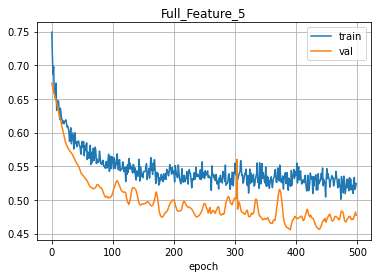

In [67]:
save_plot(losses, title='Full_Feature_5')

EVAL-XG

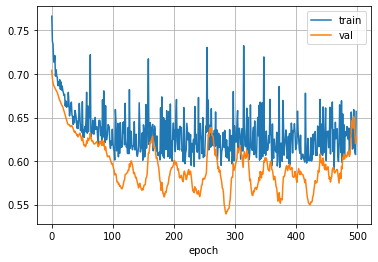

Val Accuracy: 0.6200
best model taken from epoch: 423


In [68]:
eval_xg = Model(num_features=5, mask=0, p_1 = 0.5, p_2=0.2)
eval_xg.to(device)
optimizer = torch.optim.Adam(eval_xg.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.BCELoss()

def train(epoch):
    eval_xg.train()
    optimizer.zero_grad()  # Clear gradients.
    out = eval_xg(data.x, data.edge_index)  # Perform a single forward pass.
    loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    return loss

losses = {'train':[], 'val': []}

max_epoch = 500

best_loss = 100
final_epoch = 0

for epoch in range(1, max_epoch):
    loss = train(epoch)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')
    train_batch_losses = []
    train_batch_losses.append(loss.cpu())
    val_batch_losses = []
    val_loss, val_acc = validate(eval_xg)
    val_batch_losses.append(val_loss.cpu())
    
    if epoch>(max_epoch-100) and val_loss < best_loss:
        torch.save(eval_xg.state_dict(), './Models/eval_xg_5.pt')
        best_loss = val_loss
        final_epoch = epoch
    
    losses['train'].append(train_batch_losses)
    losses['val'].append(val_batch_losses)
    live_plot(losses)
    print(f'Val Accuracy: {val_acc:.4f}')
    print('best model taken from epoch:', final_epoch)

In [69]:
eval_xg = Model(num_features=5, mask=0, p_1 = 0, p_2=0)
eval_xg.load_state_dict(torch.load('./Models/eval_xg_5.pt'))
eval_xg.to(device)
eval_xg.change_param(0,0,0)
_, val_acc = validate(eval_xg)
print('Validation:',val_acc)
test_acc = test(eval_xg)
print('Test:',test_acc)
test_masked_acc = test_eval(eval_xg)
print('Test on Masked Unimp:',test_masked_acc)

Validation: 0.7466666666666667
Test: 0.7466666666666667
Test on Masked Unimp: 0.75


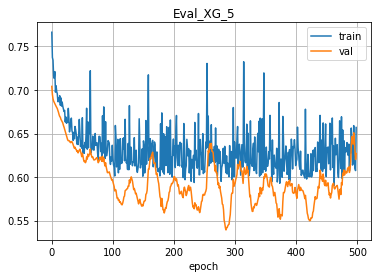

In [70]:
save_plot(losses, title='Eval_XG_5')

EVALUATING EXPLANATIONS

In [28]:
@torch.no_grad()
def Explain_Samples(X,E,mask,node_feat_mask,edge_mask,num_feat,num_edge):
    '''
    Create a data samples given the explanation
    This function will only retain features and edges indicated as important from the dataset
    X: Node Features
    E: Edge Index
    mask: Mask Token to mask features
    node_feat_mask: Node Feature Mask returned by GNNExplainer
    edge_mask: Edge Mask returned by GNNExplainer
    num_feat: Number of Top Features to include in Data
    num_edge: Number of Top Edges to include in Data
    '''
    ## Get the top num_edge important edges
    n = edge_mask.size()[0]
    imp_e_indexes = torch.zeros(num_edge,)
    for i in range(num_edge):
        e_index = torch.argmax(edge_mask)
        edge_mask[e_index] = -1
        imp_e_indexes[i,] = e_index
    imp_e_indexes = imp_e_indexes.type(torch.LongTensor)
    Sample_Adj = E[:, imp_e_indexes]
    
    f = X.size()[1]
    imp_f_indexes = torch.zeros(num_feat,)
    for i in range(num_feat):
        f_index = torch.argmax(node_feat_mask)
        node_feat_mask[f_index] = -1
        imp_f_indexes[i,] = f_index
    imp_f_indexes = imp_f_indexes.type(torch.LongTensor)
    imp_f = torch.zeros(f,)
    imp_f[imp_f_indexes] = 1
    imp_f = imp_f.type(torch.LongTensor).to(device)
    mask = torch.as_tensor(mask, dtype=torch.float).to(device)
    Sample_Ft = torch.where(imp_f == 1, data.x.float(), mask)
  
    return Sample_Ft, Sample_Adj

Explain node 0: 100%|██████████| 200/200 [00:00<00:00, 206.72it/s]


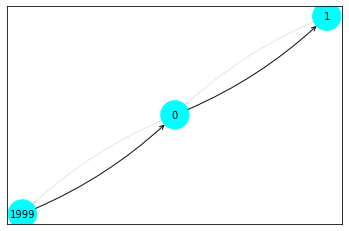

======NODE FEATURES=======
The important indexes:
 tensor([[0],
        [1],
        [2],
        [3],
        [4]], device='cuda:0')
The number of important features:
 tensor(5, device='cuda:0')
The Nonzero Values in node feat mask:
 tensor([[0.1472],
        [0.1470],
        [0.1510],
        [0.1375],
        [0.1450]], device='cuda:0')



======EDGES========
The important indexes:
 tensor([[   0],
        [   2],
        [3998]], device='cuda:0')
Corresponding actual edges:
 tensor([[[   0],
         [   1],
         [1999]],

        [[   1],
         [   0],
         [   0]]], device='cuda:0')
The number of important edges:
 tensor(3, device='cuda:0')
The Nonzero Values in edge mask:
 tensor([[0.9596],
        [0.0757],
        [0.9472]], device='cuda:0')
tensor([[   0,    0,    1,  ..., 1998, 1999, 1999],
        [   1, 1999,    0,  ..., 1999,    0, 1998]], device='cuda:0')


In [29]:
### TO CHECK WHETHER OUR FUNCTION Explain_Samples is working
explainer = GNNExplainer(model, epochs=200, return_type='log_prob')
explainer.to(device)
node_idx = 0
node_feat_mask, edge_mask = explainer.explain_node(node_idx, data.x, data.edge_index)
ax, G = explainer.visualize_subgraph(node_idx, data.edge_index, edge_mask, y=data.y)
plt.show()

## FOR NODE FEATURES
f = node_feat_mask>0.1
print("======NODE FEATURES=======")
print('The important indexes:\n',(f == 1).nonzero())
print('The number of important features:\n',f.sum())
f2 = torch.mul(node_feat_mask,f)
f2 = f2[f2.nonzero()]
print('The Nonzero Values in node feat mask:\n',f2)

print('\n\n')

## FOR EDGES
print("======EDGES========")
e = edge_mask > 0.05
print('The important indexes:\n',(e == 1).nonzero())
print('Corresponding actual edges:\n', data.edge_index[:,(e == 1).nonzero()])
print('The number of important edges:\n',e.sum())
e2 = torch.mul(edge_mask,e)
e2 = e2[e2.nonzero()]
print('The Nonzero Values in edge mask:\n',e2)
print(data.edge_index)


In [30]:
SF,SA = Explain_Samples(data.x,data.edge_index,0,node_feat_mask,edge_mask,3,2)
print(SF)
print(SA)

tensor([[ 2.0409, 26.1592,  6.1592,  0.0000,  0.0000],
        [10.7611,  0.2708,  0.1058,  0.0000,  0.0000],
        [ 3.2084,  0.6710,  3.2888,  0.0000,  0.0000],
        ...,
        [21.4348,  0.2777,  4.1395,  0.0000,  0.0000],
        [ 0.3854,  4.6018, 10.4987,  0.0000,  0.0000],
        [ 3.1831,  0.0618, 11.8545,  0.0000,  0.0000]], device='cuda:0')
tensor([[   0, 1999],
        [   1,    0]], device='cuda:0')


In [31]:
@torch.no_grad()
def forward_explain(model,Sample_Ft,Sample_Adj,node_idx):
    model.eval()
    model.mask_off()
    out = model(Sample_Ft,Sample_Adj)
    pred = torch.round(out) # Use the class with highest probability.
    correct = 0
    if pred[node_idx,:] == data.y[node_idx,:]:
        correct = 1
    return correct

Experiment 1: Run GNNExplainer on model (full feature), test its performance on model and Eval-XG

In [71]:
explainer = GNNExplainer(model, epochs=200, return_type='log_prob')
explainer.to(device)
model_total_correct = 0
eval_xg_total_correct = 0
count = 0
for i in range(V):
    if data.test_mask[i]==False:
        continue
    count+=1
    node_idx = i
    node_feat_mask, edge_mask = explainer.explain_node(node_idx, data.x, data.edge_index)
    SF, SA = Explain_Samples(data.x,data.edge_index,0,node_feat_mask,edge_mask,3,2)
    
    model_correct = forward_explain(model,SF,SA,node_idx)
    model_total_correct += model_correct
    
    eval_xg_correct = forward_explain(eval_xg,SF,SA,node_idx)
    eval_xg_total_correct += eval_xg_correct
    
    print("Accuracy on Model: ", model_total_correct/count * 100)
    print("Accuracy on EVAL-XG: ", eval_xg_total_correct/count * 100)
    

print('Model Total Accuracy: ', model_total_correct/count * 100)
print("EVAL-XG Total Accuracy: ", eval_xg_total_correct/count * 100)   
    


Explain node 1700: 100%|██████████| 200/200 [00:00<00:00, 214.87it/s]


Accuracy on Model:  0.0
Accuracy on EVAL-XG:  0.0



Explain node 1701: 100%|██████████| 200/200 [00:00<00:00, 217.78it/s]


Accuracy on Model:  50.0
Accuracy on EVAL-XG:  50.0



Explain node 1702: 100%|██████████| 200/200 [00:00<00:00, 207.27it/s]


Accuracy on Model:  33.33333333333333
Accuracy on EVAL-XG:  33.33333333333333



Explain node 1703: 100%|██████████| 200/200 [00:00<00:00, 211.45it/s]


Accuracy on Model:  25.0
Accuracy on EVAL-XG:  25.0



Explain node 1704: 100%|██████████| 200/200 [00:00<00:00, 205.52it/s]


Accuracy on Model:  20.0
Accuracy on EVAL-XG:  20.0



Explain node 1705: 100%|██████████| 200/200 [00:00<00:00, 219.29it/s]


Accuracy on Model:  16.666666666666664
Accuracy on EVAL-XG:  33.33333333333333



Explain node 1706: 100%|██████████| 200/200 [00:00<00:00, 217.62it/s]


Accuracy on Model:  28.57142857142857
Accuracy on EVAL-XG:  42.857142857142854



Explain node 1707: 100%|██████████| 200/200 [00:00<00:00, 210.52it/s]


Accuracy on Model:  25.0
Accuracy on EVAL-XG:  37.5



Explain node 1708: 100%|██████████| 200/200 [00:00<00:00, 214.44it/s]


Accuracy on Model:  33.33333333333333
Accuracy on EVAL-XG:  44.44444444444444



Explain node 1709: 100%|██████████| 200/200 [00:00<00:00, 210.93it/s]


Accuracy on Model:  40.0
Accuracy on EVAL-XG:  50.0



Explain node 1710: 100%|██████████| 200/200 [00:00<00:00, 216.48it/s]


Accuracy on Model:  36.36363636363637
Accuracy on EVAL-XG:  54.54545454545454



Explain node 1711: 100%|██████████| 200/200 [00:00<00:00, 216.89it/s]


Accuracy on Model:  33.33333333333333
Accuracy on EVAL-XG:  50.0



Explain node 1712: 100%|██████████| 200/200 [00:00<00:00, 211.53it/s]


Accuracy on Model:  30.76923076923077
Accuracy on EVAL-XG:  53.84615384615385



Explain node 1713: 100%|██████████| 200/200 [00:00<00:00, 203.43it/s]


Accuracy on Model:  35.714285714285715
Accuracy on EVAL-XG:  57.14285714285714



Explain node 1714: 100%|██████████| 200/200 [00:00<00:00, 203.36it/s]


Accuracy on Model:  33.33333333333333
Accuracy on EVAL-XG:  53.333333333333336



Explain node 1715: 100%|██████████| 200/200 [00:00<00:00, 210.82it/s]


Accuracy on Model:  37.5
Accuracy on EVAL-XG:  56.25



Explain node 1716: 100%|██████████| 200/200 [00:00<00:00, 220.95it/s]


Accuracy on Model:  35.294117647058826
Accuracy on EVAL-XG:  52.94117647058824



Explain node 1717: 100%|██████████| 200/200 [00:00<00:00, 220.93it/s]


Accuracy on Model:  38.88888888888889
Accuracy on EVAL-XG:  55.55555555555556



Explain node 1718: 100%|██████████| 200/200 [00:00<00:00, 218.43it/s]


Accuracy on Model:  42.10526315789473
Accuracy on EVAL-XG:  57.89473684210527



Explain node 1719: 100%|██████████| 200/200 [00:01<00:00, 199.34it/s]


Accuracy on Model:  40.0
Accuracy on EVAL-XG:  60.0



Explain node 1720: 100%|██████████| 200/200 [00:01<00:00, 199.76it/s]


Accuracy on Model:  42.857142857142854
Accuracy on EVAL-XG:  61.904761904761905



Explain node 1721: 100%|██████████| 200/200 [00:00<00:00, 207.53it/s]


Accuracy on Model:  45.45454545454545
Accuracy on EVAL-XG:  63.63636363636363



Explain node 1722: 100%|██████████| 200/200 [00:00<00:00, 202.07it/s]


Accuracy on Model:  43.47826086956522
Accuracy on EVAL-XG:  65.21739130434783



Explain node 1723: 100%|██████████| 200/200 [00:00<00:00, 214.74it/s]


Accuracy on Model:  41.66666666666667
Accuracy on EVAL-XG:  62.5



Explain node 1724: 100%|██████████| 200/200 [00:00<00:00, 213.31it/s]


Accuracy on Model:  44.0
Accuracy on EVAL-XG:  64.0



Explain node 1725: 100%|██████████| 200/200 [00:00<00:00, 222.90it/s]


Accuracy on Model:  46.15384615384615
Accuracy on EVAL-XG:  65.38461538461539



Explain node 1726: 100%|██████████| 200/200 [00:00<00:00, 211.98it/s]


Accuracy on Model:  44.44444444444444
Accuracy on EVAL-XG:  62.96296296296296



Explain node 1727: 100%|██████████| 200/200 [00:00<00:00, 223.15it/s]


Accuracy on Model:  42.857142857142854
Accuracy on EVAL-XG:  60.71428571428571



Explain node 1728: 100%|██████████| 200/200 [00:00<00:00, 217.38it/s]


Accuracy on Model:  41.37931034482759
Accuracy on EVAL-XG:  58.620689655172406



Explain node 1729: 100%|██████████| 200/200 [00:00<00:00, 215.64it/s]


Accuracy on Model:  43.333333333333336
Accuracy on EVAL-XG:  60.0



Explain node 1730: 100%|██████████| 200/200 [00:00<00:00, 216.86it/s]


Accuracy on Model:  41.935483870967744
Accuracy on EVAL-XG:  58.06451612903226



Explain node 1731: 100%|██████████| 200/200 [00:00<00:00, 217.91it/s]


Accuracy on Model:  43.75
Accuracy on EVAL-XG:  59.375



Explain node 1732: 100%|██████████| 200/200 [00:00<00:00, 211.74it/s]


Accuracy on Model:  42.42424242424242
Accuracy on EVAL-XG:  57.57575757575758



Explain node 1733: 100%|██████████| 200/200 [00:00<00:00, 210.97it/s]


Accuracy on Model:  41.17647058823529
Accuracy on EVAL-XG:  55.88235294117647



Explain node 1734: 100%|██████████| 200/200 [00:00<00:00, 213.99it/s]


Accuracy on Model:  40.0
Accuracy on EVAL-XG:  54.285714285714285



Explain node 1735: 100%|██████████| 200/200 [00:00<00:00, 215.96it/s]


Accuracy on Model:  41.66666666666667
Accuracy on EVAL-XG:  55.55555555555556



Explain node 1736: 100%|██████████| 200/200 [00:00<00:00, 219.88it/s]


Accuracy on Model:  40.54054054054054
Accuracy on EVAL-XG:  54.054054054054056



Explain node 1737: 100%|██████████| 200/200 [00:00<00:00, 207.87it/s]


Accuracy on Model:  42.10526315789473
Accuracy on EVAL-XG:  55.26315789473685



Explain node 1738: 100%|██████████| 200/200 [00:00<00:00, 209.18it/s]


Accuracy on Model:  43.58974358974359
Accuracy on EVAL-XG:  56.41025641025641



Explain node 1739: 100%|██████████| 200/200 [00:00<00:00, 212.03it/s]


Accuracy on Model:  42.5
Accuracy on EVAL-XG:  55.00000000000001



Explain node 1740: 100%|██████████| 200/200 [00:00<00:00, 214.59it/s]


Accuracy on Model:  41.46341463414634
Accuracy on EVAL-XG:  53.65853658536586



Explain node 1741: 100%|██████████| 200/200 [00:00<00:00, 215.52it/s]


Accuracy on Model:  40.476190476190474
Accuracy on EVAL-XG:  52.38095238095239



Explain node 1742: 100%|██████████| 200/200 [00:00<00:00, 212.17it/s]


Accuracy on Model:  41.86046511627907
Accuracy on EVAL-XG:  53.48837209302325



Explain node 1743: 100%|██████████| 200/200 [00:00<00:00, 210.07it/s]


Accuracy on Model:  40.909090909090914
Accuracy on EVAL-XG:  52.27272727272727



Explain node 1744: 100%|██████████| 200/200 [00:00<00:00, 217.50it/s]


Accuracy on Model:  42.22222222222222
Accuracy on EVAL-XG:  53.333333333333336



Explain node 1745: 100%|██████████| 200/200 [00:00<00:00, 208.66it/s]


Accuracy on Model:  41.30434782608695
Accuracy on EVAL-XG:  52.17391304347826



Explain node 1746: 100%|██████████| 200/200 [00:00<00:00, 217.96it/s]


Accuracy on Model:  40.42553191489361
Accuracy on EVAL-XG:  51.06382978723404



Explain node 1747: 100%|██████████| 200/200 [00:00<00:00, 221.10it/s]


Accuracy on Model:  41.66666666666667
Accuracy on EVAL-XG:  52.083333333333336



Explain node 1748: 100%|██████████| 200/200 [00:00<00:00, 221.51it/s]


Accuracy on Model:  42.857142857142854
Accuracy on EVAL-XG:  53.06122448979592



Explain node 1749: 100%|██████████| 200/200 [00:00<00:00, 212.59it/s]


Accuracy on Model:  44.0
Accuracy on EVAL-XG:  54.0



Explain node 1750: 100%|██████████| 200/200 [00:01<00:00, 191.63it/s]


Accuracy on Model:  45.09803921568628
Accuracy on EVAL-XG:  54.90196078431373



Explain node 1751: 100%|██████████| 200/200 [00:00<00:00, 213.39it/s]


Accuracy on Model:  46.15384615384615
Accuracy on EVAL-XG:  55.769230769230774



Explain node 1752: 100%|██████████| 200/200 [00:00<00:00, 222.18it/s]


Accuracy on Model:  47.16981132075472
Accuracy on EVAL-XG:  56.60377358490566



Explain node 1753: 100%|██████████| 200/200 [00:00<00:00, 213.13it/s]


Accuracy on Model:  48.148148148148145
Accuracy on EVAL-XG:  57.407407407407405



Explain node 1754: 100%|██████████| 200/200 [00:00<00:00, 211.39it/s]


Accuracy on Model:  47.27272727272727
Accuracy on EVAL-XG:  56.36363636363636



Explain node 1755: 100%|██████████| 200/200 [00:00<00:00, 203.80it/s]


Accuracy on Model:  48.214285714285715
Accuracy on EVAL-XG:  57.14285714285714



Explain node 1756: 100%|██████████| 200/200 [00:00<00:00, 215.04it/s]


Accuracy on Model:  47.368421052631575
Accuracy on EVAL-XG:  57.89473684210527



Explain node 1757: 100%|██████████| 200/200 [00:00<00:00, 213.62it/s]


Accuracy on Model:  48.275862068965516
Accuracy on EVAL-XG:  58.620689655172406



Explain node 1758: 100%|██████████| 200/200 [00:00<00:00, 217.04it/s]


Accuracy on Model:  47.45762711864407
Accuracy on EVAL-XG:  59.32203389830508



Explain node 1759: 100%|██████████| 200/200 [00:00<00:00, 219.89it/s]


Accuracy on Model:  46.666666666666664
Accuracy on EVAL-XG:  58.333333333333336



Explain node 1760: 100%|██████████| 200/200 [00:00<00:00, 207.59it/s]


Accuracy on Model:  45.90163934426229
Accuracy on EVAL-XG:  57.377049180327866



Explain node 1761: 100%|██████████| 200/200 [00:00<00:00, 217.99it/s]


Accuracy on Model:  46.774193548387096
Accuracy on EVAL-XG:  58.06451612903226



Explain node 1762: 100%|██████████| 200/200 [00:00<00:00, 217.60it/s]


Accuracy on Model:  47.61904761904761
Accuracy on EVAL-XG:  58.730158730158735



Explain node 1763: 100%|██████████| 200/200 [00:00<00:00, 217.29it/s]


Accuracy on Model:  46.875
Accuracy on EVAL-XG:  57.8125



Explain node 1764: 100%|██████████| 200/200 [00:00<00:00, 204.97it/s]


Accuracy on Model:  47.69230769230769
Accuracy on EVAL-XG:  58.46153846153847



Explain node 1765: 100%|██████████| 200/200 [00:00<00:00, 217.15it/s]


Accuracy on Model:  46.96969696969697
Accuracy on EVAL-XG:  57.57575757575758



Explain node 1766: 100%|██████████| 200/200 [00:00<00:00, 208.15it/s]


Accuracy on Model:  46.26865671641791
Accuracy on EVAL-XG:  56.71641791044776



Explain node 1767: 100%|██████████| 200/200 [00:00<00:00, 213.09it/s]


Accuracy on Model:  45.588235294117645
Accuracy on EVAL-XG:  55.88235294117647



Explain node 1768: 100%|██████████| 200/200 [00:00<00:00, 210.44it/s]


Accuracy on Model:  44.927536231884055
Accuracy on EVAL-XG:  55.072463768115945



Explain node 1769: 100%|██████████| 200/200 [00:00<00:00, 208.87it/s]


Accuracy on Model:  44.285714285714285
Accuracy on EVAL-XG:  54.285714285714285



Explain node 1770: 100%|██████████| 200/200 [00:00<00:00, 212.67it/s]


Accuracy on Model:  43.66197183098591
Accuracy on EVAL-XG:  54.929577464788736



Explain node 1771: 100%|██████████| 200/200 [00:00<00:00, 209.35it/s]


Accuracy on Model:  44.44444444444444
Accuracy on EVAL-XG:  55.55555555555556



Explain node 1772: 100%|██████████| 200/200 [00:00<00:00, 204.34it/s]


Accuracy on Model:  45.20547945205479
Accuracy on EVAL-XG:  56.16438356164384



Explain node 1773: 100%|██████████| 200/200 [00:00<00:00, 212.04it/s]


Accuracy on Model:  44.5945945945946
Accuracy on EVAL-XG:  55.4054054054054



Explain node 1774: 100%|██████████| 200/200 [00:00<00:00, 214.04it/s]


Accuracy on Model:  44.0
Accuracy on EVAL-XG:  54.666666666666664



Explain node 1775: 100%|██████████| 200/200 [00:00<00:00, 212.43it/s]


Accuracy on Model:  43.42105263157895
Accuracy on EVAL-XG:  53.94736842105263



Explain node 1776: 100%|██████████| 200/200 [00:01<00:00, 180.31it/s]


Accuracy on Model:  44.15584415584416
Accuracy on EVAL-XG:  54.54545454545454



Explain node 1777: 100%|██████████| 200/200 [00:01<00:00, 198.56it/s]


Accuracy on Model:  44.871794871794876
Accuracy on EVAL-XG:  55.12820512820513



Explain node 1778: 100%|██████████| 200/200 [00:00<00:00, 216.46it/s]


Accuracy on Model:  45.56962025316456
Accuracy on EVAL-XG:  55.69620253164557



Explain node 1779: 100%|██████████| 200/200 [00:00<00:00, 217.54it/s]


Accuracy on Model:  46.25
Accuracy on EVAL-XG:  56.25



Explain node 1780: 100%|██████████| 200/200 [00:00<00:00, 213.52it/s]


Accuracy on Model:  46.913580246913575
Accuracy on EVAL-XG:  56.79012345679012



Explain node 1781: 100%|██████████| 200/200 [00:00<00:00, 211.94it/s]


Accuracy on Model:  47.5609756097561
Accuracy on EVAL-XG:  57.3170731707317



Explain node 1782: 100%|██████████| 200/200 [00:00<00:00, 212.19it/s]


Accuracy on Model:  48.19277108433735
Accuracy on EVAL-XG:  57.831325301204814



Explain node 1783: 100%|██████████| 200/200 [00:01<00:00, 198.82it/s]


Accuracy on Model:  48.80952380952381
Accuracy on EVAL-XG:  58.333333333333336



Explain node 1784: 100%|██████████| 200/200 [00:00<00:00, 203.75it/s]


Accuracy on Model:  49.411764705882355
Accuracy on EVAL-XG:  58.82352941176471



Explain node 1785: 100%|██████████| 200/200 [00:00<00:00, 208.30it/s]


Accuracy on Model:  48.837209302325576
Accuracy on EVAL-XG:  58.139534883720934



Explain node 1786: 100%|██████████| 200/200 [00:00<00:00, 214.46it/s]


Accuracy on Model:  48.275862068965516
Accuracy on EVAL-XG:  58.620689655172406



Explain node 1787: 100%|██████████| 200/200 [00:00<00:00, 218.38it/s]


Accuracy on Model:  47.72727272727273
Accuracy on EVAL-XG:  57.95454545454546



Explain node 1788: 100%|██████████| 200/200 [00:00<00:00, 218.24it/s]


Accuracy on Model:  47.19101123595505
Accuracy on EVAL-XG:  57.30337078651685



Explain node 1789: 100%|██████████| 200/200 [00:00<00:00, 215.48it/s]


Accuracy on Model:  46.666666666666664
Accuracy on EVAL-XG:  56.666666666666664



Explain node 1790: 100%|██████████| 200/200 [00:00<00:00, 213.99it/s]


Accuracy on Model:  46.15384615384615
Accuracy on EVAL-XG:  56.043956043956044



Explain node 1791: 100%|██████████| 200/200 [00:00<00:00, 204.59it/s]


Accuracy on Model:  45.65217391304348
Accuracy on EVAL-XG:  56.52173913043478



Explain node 1792: 100%|██████████| 200/200 [00:00<00:00, 204.06it/s]


Accuracy on Model:  46.236559139784944
Accuracy on EVAL-XG:  56.98924731182796



Explain node 1793: 100%|██████████| 200/200 [00:00<00:00, 207.65it/s]


Accuracy on Model:  45.744680851063826
Accuracy on EVAL-XG:  56.38297872340425



Explain node 1794: 100%|██████████| 200/200 [00:00<00:00, 216.26it/s]


Accuracy on Model:  45.26315789473684
Accuracy on EVAL-XG:  55.78947368421052



Explain node 1795: 100%|██████████| 200/200 [00:00<00:00, 216.94it/s]


Accuracy on Model:  44.79166666666667
Accuracy on EVAL-XG:  55.208333333333336



Explain node 1796: 100%|██████████| 200/200 [00:00<00:00, 213.40it/s]


Accuracy on Model:  44.329896907216494
Accuracy on EVAL-XG:  54.63917525773196



Explain node 1797: 100%|██████████| 200/200 [00:00<00:00, 211.61it/s]


Accuracy on Model:  43.87755102040816
Accuracy on EVAL-XG:  54.08163265306123



Explain node 1798: 100%|██████████| 200/200 [00:00<00:00, 203.71it/s]


Accuracy on Model:  43.43434343434344
Accuracy on EVAL-XG:  53.535353535353536



Explain node 1799: 100%|██████████| 200/200 [00:00<00:00, 219.75it/s]


Accuracy on Model:  44.0
Accuracy on EVAL-XG:  54.0



Explain node 1800: 100%|██████████| 200/200 [00:00<00:00, 218.34it/s]


Accuracy on Model:  43.56435643564357
Accuracy on EVAL-XG:  53.46534653465347



Explain node 1801: 100%|██████████| 200/200 [00:00<00:00, 205.91it/s]


Accuracy on Model:  43.13725490196079
Accuracy on EVAL-XG:  53.92156862745098



Explain node 1802: 100%|██████████| 200/200 [00:00<00:00, 214.35it/s]


Accuracy on Model:  43.689320388349515
Accuracy on EVAL-XG:  54.36893203883495



Explain node 1803: 100%|██████████| 200/200 [00:00<00:00, 211.51it/s]


Accuracy on Model:  44.230769230769226
Accuracy on EVAL-XG:  54.807692307692314



Explain node 1804: 100%|██████████| 200/200 [00:00<00:00, 216.29it/s]


Accuracy on Model:  43.80952380952381
Accuracy on EVAL-XG:  55.23809523809524



Explain node 1805: 100%|██████████| 200/200 [00:00<00:00, 213.33it/s]


Accuracy on Model:  43.39622641509434
Accuracy on EVAL-XG:  54.71698113207547



Explain node 1806: 100%|██████████| 200/200 [00:00<00:00, 202.59it/s]


Accuracy on Model:  43.925233644859816
Accuracy on EVAL-XG:  55.140186915887845



Explain node 1807: 100%|██████████| 200/200 [00:01<00:00, 199.99it/s]


Accuracy on Model:  44.44444444444444
Accuracy on EVAL-XG:  55.55555555555556



Explain node 1808: 100%|██████████| 200/200 [00:00<00:00, 217.74it/s]


Accuracy on Model:  44.95412844036697
Accuracy on EVAL-XG:  55.96330275229357



Explain node 1809: 100%|██████████| 200/200 [00:00<00:00, 216.14it/s]


Accuracy on Model:  45.45454545454545
Accuracy on EVAL-XG:  56.36363636363636



Explain node 1810: 100%|██████████| 200/200 [00:00<00:00, 221.86it/s]


Accuracy on Model:  45.04504504504504
Accuracy on EVAL-XG:  55.85585585585585



Explain node 1811: 100%|██████████| 200/200 [00:00<00:00, 216.04it/s]


Accuracy on Model:  44.642857142857146
Accuracy on EVAL-XG:  55.35714285714286



Explain node 1812: 100%|██████████| 200/200 [00:00<00:00, 208.95it/s]


Accuracy on Model:  45.13274336283185
Accuracy on EVAL-XG:  55.75221238938053



Explain node 1813: 100%|██████████| 200/200 [00:00<00:00, 211.60it/s]


Accuracy on Model:  44.73684210526316
Accuracy on EVAL-XG:  55.26315789473685



Explain node 1814: 100%|██████████| 200/200 [00:00<00:00, 215.98it/s]


Accuracy on Model:  45.21739130434783
Accuracy on EVAL-XG:  55.65217391304348



Explain node 1815: 100%|██████████| 200/200 [00:00<00:00, 217.82it/s]


Accuracy on Model:  45.689655172413794
Accuracy on EVAL-XG:  56.03448275862068



Explain node 1816: 100%|██████████| 200/200 [00:00<00:00, 215.85it/s]


Accuracy on Model:  45.2991452991453
Accuracy on EVAL-XG:  56.41025641025641



Explain node 1817: 100%|██████████| 200/200 [00:00<00:00, 213.05it/s]


Accuracy on Model:  44.91525423728814
Accuracy on EVAL-XG:  55.932203389830505



Explain node 1818: 100%|██████████| 200/200 [00:01<00:00, 198.76it/s]


Accuracy on Model:  44.537815126050425
Accuracy on EVAL-XG:  55.46218487394958



Explain node 1819: 100%|██████████| 200/200 [00:00<00:00, 203.48it/s]


Accuracy on Model:  44.166666666666664
Accuracy on EVAL-XG:  55.833333333333336



Explain node 1820: 100%|██████████| 200/200 [00:00<00:00, 216.47it/s]


Accuracy on Model:  44.62809917355372
Accuracy on EVAL-XG:  56.19834710743802



Explain node 1821: 100%|██████████| 200/200 [00:00<00:00, 209.91it/s]


Accuracy on Model:  44.26229508196721
Accuracy on EVAL-XG:  55.73770491803278



Explain node 1822: 100%|██████████| 200/200 [00:00<00:00, 218.76it/s]


Accuracy on Model:  44.71544715447154
Accuracy on EVAL-XG:  56.09756097560976



Explain node 1823: 100%|██████████| 200/200 [00:00<00:00, 215.50it/s]


Accuracy on Model:  45.16129032258064
Accuracy on EVAL-XG:  56.451612903225815



Explain node 1824: 100%|██████████| 200/200 [00:00<00:00, 211.11it/s]


Accuracy on Model:  44.800000000000004
Accuracy on EVAL-XG:  56.00000000000001



Explain node 1825: 100%|██████████| 200/200 [00:00<00:00, 204.15it/s]


Accuracy on Model:  45.23809523809524
Accuracy on EVAL-XG:  56.34920634920635



Explain node 1826: 100%|██████████| 200/200 [00:00<00:00, 206.63it/s]


Accuracy on Model:  45.66929133858268
Accuracy on EVAL-XG:  56.69291338582677



Explain node 1827: 100%|██████████| 200/200 [00:00<00:00, 212.09it/s]


Accuracy on Model:  45.3125
Accuracy on EVAL-XG:  56.25



Explain node 1828: 100%|██████████| 200/200 [00:00<00:00, 214.87it/s]


Accuracy on Model:  45.73643410852713
Accuracy on EVAL-XG:  56.58914728682171



Explain node 1829: 100%|██████████| 200/200 [00:00<00:00, 204.49it/s]


Accuracy on Model:  45.38461538461539
Accuracy on EVAL-XG:  56.15384615384615



Explain node 1830: 100%|██████████| 200/200 [00:00<00:00, 206.91it/s]


Accuracy on Model:  45.80152671755725
Accuracy on EVAL-XG:  56.48854961832062



Explain node 1831: 100%|██████████| 200/200 [00:00<00:00, 214.51it/s]


Accuracy on Model:  46.21212121212121
Accuracy on EVAL-XG:  56.81818181818182



Explain node 1832: 100%|██████████| 200/200 [00:00<00:00, 217.64it/s]


Accuracy on Model:  46.616541353383454
Accuracy on EVAL-XG:  57.14285714285714



Explain node 1833: 100%|██████████| 200/200 [00:00<00:00, 214.76it/s]


Accuracy on Model:  47.01492537313433
Accuracy on EVAL-XG:  57.46268656716418



Explain node 1834: 100%|██████████| 200/200 [00:00<00:00, 218.09it/s]


Accuracy on Model:  46.666666666666664
Accuracy on EVAL-XG:  57.03703703703704



Explain node 1835: 100%|██████████| 200/200 [00:00<00:00, 218.03it/s]


Accuracy on Model:  47.05882352941176
Accuracy on EVAL-XG:  57.35294117647059



Explain node 1836: 100%|██████████| 200/200 [00:00<00:00, 224.86it/s]


Accuracy on Model:  46.715328467153284
Accuracy on EVAL-XG:  56.934306569343065



Explain node 1837: 100%|██████████| 200/200 [00:00<00:00, 220.07it/s]


Accuracy on Model:  46.3768115942029
Accuracy on EVAL-XG:  56.52173913043478



Explain node 1838: 100%|██████████| 200/200 [00:00<00:00, 218.72it/s]


Accuracy on Model:  46.043165467625904
Accuracy on EVAL-XG:  56.11510791366906



Explain node 1839: 100%|██████████| 200/200 [00:00<00:00, 210.90it/s]


Accuracy on Model:  46.42857142857143
Accuracy on EVAL-XG:  56.42857142857143



Explain node 1840: 100%|██████████| 200/200 [00:00<00:00, 213.58it/s]


Accuracy on Model:  46.808510638297875
Accuracy on EVAL-XG:  56.73758865248227



Explain node 1841: 100%|██████████| 200/200 [00:00<00:00, 213.78it/s]


Accuracy on Model:  46.478873239436616
Accuracy on EVAL-XG:  56.33802816901409



Explain node 1842: 100%|██████████| 200/200 [00:00<00:00, 220.90it/s]


Accuracy on Model:  46.85314685314685
Accuracy on EVAL-XG:  56.64335664335665



Explain node 1843: 100%|██████████| 200/200 [00:00<00:00, 218.45it/s]


Accuracy on Model:  47.22222222222222
Accuracy on EVAL-XG:  56.94444444444444



Explain node 1844: 100%|██████████| 200/200 [00:00<00:00, 218.74it/s]


Accuracy on Model:  47.58620689655172
Accuracy on EVAL-XG:  57.24137931034483



Explain node 1845: 100%|██████████| 200/200 [00:00<00:00, 209.70it/s]


Accuracy on Model:  47.94520547945205
Accuracy on EVAL-XG:  57.534246575342465



Explain node 1846: 100%|██████████| 200/200 [00:00<00:00, 209.15it/s]


Accuracy on Model:  47.61904761904761
Accuracy on EVAL-XG:  57.14285714285714



Explain node 1847: 100%|██████████| 200/200 [00:00<00:00, 202.80it/s]


Accuracy on Model:  47.2972972972973
Accuracy on EVAL-XG:  57.432432432432435



Explain node 1848: 100%|██████████| 200/200 [00:00<00:00, 208.17it/s]


Accuracy on Model:  47.651006711409394
Accuracy on EVAL-XG:  57.04697986577181



Explain node 1849: 100%|██████████| 200/200 [00:00<00:00, 213.34it/s]


Accuracy on Model:  48.0
Accuracy on EVAL-XG:  57.333333333333336



Explain node 1850: 100%|██████████| 200/200 [00:00<00:00, 218.46it/s]


Accuracy on Model:  47.682119205298015
Accuracy on EVAL-XG:  56.95364238410596



Explain node 1851: 100%|██████████| 200/200 [00:00<00:00, 222.27it/s]


Accuracy on Model:  47.368421052631575
Accuracy on EVAL-XG:  57.23684210526315



Explain node 1852: 100%|██████████| 200/200 [00:00<00:00, 219.42it/s]


Accuracy on Model:  47.05882352941176
Accuracy on EVAL-XG:  56.86274509803921



Explain node 1853: 100%|██████████| 200/200 [00:00<00:00, 207.98it/s]


Accuracy on Model:  47.4025974025974
Accuracy on EVAL-XG:  57.14285714285714



Explain node 1854: 100%|██████████| 200/200 [00:00<00:00, 210.49it/s]


Accuracy on Model:  47.74193548387097
Accuracy on EVAL-XG:  57.41935483870968



Explain node 1855: 100%|██████████| 200/200 [00:00<00:00, 222.41it/s]


Accuracy on Model:  48.07692307692308
Accuracy on EVAL-XG:  57.692307692307686



Explain node 1856: 100%|██████████| 200/200 [00:00<00:00, 214.78it/s]


Accuracy on Model:  48.40764331210191
Accuracy on EVAL-XG:  57.961783439490446



Explain node 1857: 100%|██████████| 200/200 [00:00<00:00, 216.02it/s]


Accuracy on Model:  48.734177215189874
Accuracy on EVAL-XG:  58.22784810126582



Explain node 1858: 100%|██████████| 200/200 [00:00<00:00, 212.14it/s]


Accuracy on Model:  49.056603773584904
Accuracy on EVAL-XG:  58.490566037735846



Explain node 1859: 100%|██████████| 200/200 [00:00<00:00, 216.71it/s]


Accuracy on Model:  49.375
Accuracy on EVAL-XG:  58.75



Explain node 1860: 100%|██████████| 200/200 [00:00<00:00, 217.09it/s]


Accuracy on Model:  49.68944099378882
Accuracy on EVAL-XG:  59.006211180124225



Explain node 1861: 100%|██████████| 200/200 [00:00<00:00, 209.43it/s]


Accuracy on Model:  50.0
Accuracy on EVAL-XG:  59.25925925925925



Explain node 1862: 100%|██████████| 200/200 [00:00<00:00, 211.95it/s]


Accuracy on Model:  50.306748466257666
Accuracy on EVAL-XG:  59.50920245398773



Explain node 1863: 100%|██████████| 200/200 [00:00<00:00, 213.33it/s]


Accuracy on Model:  50.609756097560975
Accuracy on EVAL-XG:  59.756097560975604



Explain node 1864: 100%|██████████| 200/200 [00:00<00:00, 220.20it/s]


Accuracy on Model:  50.90909090909091
Accuracy on EVAL-XG:  60.0



Explain node 1865: 100%|██████████| 200/200 [00:00<00:00, 211.73it/s]


Accuracy on Model:  50.602409638554214
Accuracy on EVAL-XG:  60.24096385542169



Explain node 1866: 100%|██████████| 200/200 [00:00<00:00, 212.28it/s]


Accuracy on Model:  50.29940119760479
Accuracy on EVAL-XG:  59.88023952095808



Explain node 1867: 100%|██████████| 200/200 [00:00<00:00, 212.31it/s]


Accuracy on Model:  50.595238095238095
Accuracy on EVAL-XG:  60.11904761904761



Explain node 1868: 100%|██████████| 200/200 [00:00<00:00, 214.34it/s]


Accuracy on Model:  50.887573964497044
Accuracy on EVAL-XG:  59.76331360946746



Explain node 1869: 100%|██████████| 200/200 [00:00<00:00, 202.26it/s]


Accuracy on Model:  51.17647058823529
Accuracy on EVAL-XG:  60.0



Explain node 1870: 100%|██████████| 200/200 [00:00<00:00, 217.60it/s]


Accuracy on Model:  50.877192982456144
Accuracy on EVAL-XG:  59.64912280701754



Explain node 1871: 100%|██████████| 200/200 [00:00<00:00, 216.85it/s]


Accuracy on Model:  51.162790697674424
Accuracy on EVAL-XG:  59.883720930232556



Explain node 1872: 100%|██████████| 200/200 [00:00<00:00, 215.08it/s]


Accuracy on Model:  51.445086705202314
Accuracy on EVAL-XG:  60.115606936416185



Explain node 1873: 100%|██████████| 200/200 [00:00<00:00, 214.46it/s]


Accuracy on Model:  51.14942528735632
Accuracy on EVAL-XG:  59.77011494252874



Explain node 1874: 100%|██████████| 200/200 [00:00<00:00, 213.10it/s]


Accuracy on Model:  50.857142857142854
Accuracy on EVAL-XG:  59.42857142857143



Explain node 1875: 100%|██████████| 200/200 [00:00<00:00, 213.54it/s]


Accuracy on Model:  50.56818181818182
Accuracy on EVAL-XG:  59.09090909090909



Explain node 1876: 100%|██████████| 200/200 [00:00<00:00, 212.71it/s]


Accuracy on Model:  50.847457627118644
Accuracy on EVAL-XG:  59.32203389830508



Explain node 1877: 100%|██████████| 200/200 [00:00<00:00, 214.93it/s]


Accuracy on Model:  51.12359550561798
Accuracy on EVAL-XG:  59.55056179775281



Explain node 1878: 100%|██████████| 200/200 [00:00<00:00, 213.69it/s]


Accuracy on Model:  51.39664804469274
Accuracy on EVAL-XG:  59.77653631284916



Explain node 1879: 100%|██████████| 200/200 [00:00<00:00, 209.22it/s]


Accuracy on Model:  51.66666666666667
Accuracy on EVAL-XG:  60.0



Explain node 1880: 100%|██████████| 200/200 [00:00<00:00, 209.36it/s]


Accuracy on Model:  51.93370165745856
Accuracy on EVAL-XG:  60.22099447513812



Explain node 1881: 100%|██████████| 200/200 [00:01<00:00, 198.16it/s]


Accuracy on Model:  52.197802197802204
Accuracy on EVAL-XG:  60.43956043956044



Explain node 1882: 100%|██████████| 200/200 [00:00<00:00, 216.09it/s]


Accuracy on Model:  52.459016393442624
Accuracy on EVAL-XG:  60.65573770491803



Explain node 1883: 100%|██████████| 200/200 [00:00<00:00, 222.45it/s]


Accuracy on Model:  52.17391304347826
Accuracy on EVAL-XG:  60.32608695652174



Explain node 1884: 100%|██████████| 200/200 [00:00<00:00, 215.32it/s]


Accuracy on Model:  51.891891891891895
Accuracy on EVAL-XG:  60.0



Explain node 1885: 100%|██████████| 200/200 [00:00<00:00, 211.94it/s]


Accuracy on Model:  52.1505376344086
Accuracy on EVAL-XG:  60.215053763440864



Explain node 1886: 100%|██████████| 200/200 [00:00<00:00, 209.98it/s]


Accuracy on Model:  52.406417112299465
Accuracy on EVAL-XG:  60.42780748663101



Explain node 1887: 100%|██████████| 200/200 [00:00<00:00, 213.11it/s]


Accuracy on Model:  52.659574468085104
Accuracy on EVAL-XG:  60.63829787234043



Explain node 1888: 100%|██████████| 200/200 [00:00<00:00, 209.14it/s]


Accuracy on Model:  52.38095238095239
Accuracy on EVAL-XG:  60.317460317460316



Explain node 1889: 100%|██████████| 200/200 [00:00<00:00, 219.53it/s]


Accuracy on Model:  52.10526315789473
Accuracy on EVAL-XG:  60.0



Explain node 1890: 100%|██████████| 200/200 [00:00<00:00, 215.21it/s]


Accuracy on Model:  52.35602094240838
Accuracy on EVAL-XG:  60.20942408376963



Explain node 1891: 100%|██████████| 200/200 [00:00<00:00, 215.96it/s]


Accuracy on Model:  52.083333333333336
Accuracy on EVAL-XG:  59.895833333333336



Explain node 1892: 100%|██████████| 200/200 [00:00<00:00, 214.22it/s]


Accuracy on Model:  51.813471502590666
Accuracy on EVAL-XG:  59.58549222797927



Explain node 1893: 100%|██████████| 200/200 [00:00<00:00, 219.93it/s]


Accuracy on Model:  51.546391752577314
Accuracy on EVAL-XG:  59.27835051546392



Explain node 1894: 100%|██████████| 200/200 [00:00<00:00, 214.30it/s]


Accuracy on Model:  51.7948717948718
Accuracy on EVAL-XG:  59.48717948717949



Explain node 1895: 100%|██████████| 200/200 [00:00<00:00, 222.42it/s]


Accuracy on Model:  51.53061224489795
Accuracy on EVAL-XG:  59.183673469387756



Explain node 1896: 100%|██████████| 200/200 [00:00<00:00, 223.59it/s]


Accuracy on Model:  51.776649746192895
Accuracy on EVAL-XG:  59.390862944162436



Explain node 1897: 100%|██████████| 200/200 [00:00<00:00, 221.68it/s]


Accuracy on Model:  51.515151515151516
Accuracy on EVAL-XG:  59.09090909090909



Explain node 1898: 100%|██████████| 200/200 [00:00<00:00, 221.05it/s]


Accuracy on Model:  51.75879396984925
Accuracy on EVAL-XG:  59.2964824120603



Explain node 1899: 100%|██████████| 200/200 [00:00<00:00, 214.92it/s]


Accuracy on Model:  52.0
Accuracy on EVAL-XG:  59.5



Explain node 1900: 100%|██████████| 200/200 [00:00<00:00, 209.80it/s]


Accuracy on Model:  52.23880597014925
Accuracy on EVAL-XG:  59.70149253731343



Explain node 1901: 100%|██████████| 200/200 [00:00<00:00, 223.27it/s]


Accuracy on Model:  52.475247524752476
Accuracy on EVAL-XG:  59.4059405940594



Explain node 1902: 100%|██████████| 200/200 [00:00<00:00, 204.85it/s]


Accuracy on Model:  52.70935960591133
Accuracy on EVAL-XG:  59.60591133004927



Explain node 1903: 100%|██████████| 200/200 [00:00<00:00, 212.90it/s]


Accuracy on Model:  52.450980392156865
Accuracy on EVAL-XG:  59.31372549019608



Explain node 1904: 100%|██████████| 200/200 [00:00<00:00, 217.09it/s]


Accuracy on Model:  52.19512195121951
Accuracy on EVAL-XG:  59.02439024390244



Explain node 1905: 100%|██████████| 200/200 [00:00<00:00, 225.25it/s]


Accuracy on Model:  52.42718446601942
Accuracy on EVAL-XG:  59.22330097087378



Explain node 1906: 100%|██████████| 200/200 [00:00<00:00, 225.15it/s]


Accuracy on Model:  52.65700483091788
Accuracy on EVAL-XG:  59.42028985507246



Explain node 1907: 100%|██████████| 200/200 [00:01<00:00, 199.24it/s]


Accuracy on Model:  52.88461538461539
Accuracy on EVAL-XG:  59.61538461538461



Explain node 1908: 100%|██████████| 200/200 [00:00<00:00, 215.38it/s]


Accuracy on Model:  53.110047846889955
Accuracy on EVAL-XG:  59.80861244019139



Explain node 1909: 100%|██████████| 200/200 [00:00<00:00, 204.22it/s]


Accuracy on Model:  52.85714285714286
Accuracy on EVAL-XG:  59.523809523809526



Explain node 1910: 100%|██████████| 200/200 [00:00<00:00, 206.75it/s]


Accuracy on Model:  52.60663507109005
Accuracy on EVAL-XG:  59.241706161137444



Explain node 1911: 100%|██████████| 200/200 [00:00<00:00, 210.51it/s]


Accuracy on Model:  52.358490566037744
Accuracy on EVAL-XG:  58.9622641509434



Explain node 1912: 100%|██████████| 200/200 [00:00<00:00, 208.19it/s]


Accuracy on Model:  52.58215962441315
Accuracy on EVAL-XG:  59.154929577464785



Explain node 1913: 100%|██████████| 200/200 [00:00<00:00, 220.60it/s]


Accuracy on Model:  52.336448598130836
Accuracy on EVAL-XG:  58.87850467289719



Explain node 1914: 100%|██████████| 200/200 [00:00<00:00, 214.40it/s]


Accuracy on Model:  52.093023255813954
Accuracy on EVAL-XG:  58.6046511627907



Explain node 1915: 100%|██████████| 200/200 [00:00<00:00, 203.43it/s]


Accuracy on Model:  52.31481481481482
Accuracy on EVAL-XG:  58.79629629629629



Explain node 1916: 100%|██████████| 200/200 [00:00<00:00, 211.66it/s]


Accuracy on Model:  52.53456221198156
Accuracy on EVAL-XG:  58.525345622119815



Explain node 1917: 100%|██████████| 200/200 [00:00<00:00, 220.88it/s]


Accuracy on Model:  52.752293577981646
Accuracy on EVAL-XG:  58.71559633027523



Explain node 1918: 100%|██████████| 200/200 [00:00<00:00, 216.17it/s]


Accuracy on Model:  52.96803652968036
Accuracy on EVAL-XG:  58.44748858447488



Explain node 1919: 100%|██████████| 200/200 [00:00<00:00, 209.27it/s]


Accuracy on Model:  52.72727272727272
Accuracy on EVAL-XG:  58.18181818181818



Explain node 1920: 100%|██████████| 200/200 [00:00<00:00, 217.36it/s]


Accuracy on Model:  52.94117647058824
Accuracy on EVAL-XG:  58.371040723981906



Explain node 1921: 100%|██████████| 200/200 [00:00<00:00, 204.16it/s]


Accuracy on Model:  53.153153153153156
Accuracy on EVAL-XG:  58.55855855855856



Explain node 1922: 100%|██████████| 200/200 [00:00<00:00, 225.14it/s]


Accuracy on Model:  53.36322869955157
Accuracy on EVAL-XG:  58.744394618834086



Explain node 1923: 100%|██████████| 200/200 [00:00<00:00, 209.40it/s]


Accuracy on Model:  53.125
Accuracy on EVAL-XG:  58.48214285714286



Explain node 1924: 100%|██████████| 200/200 [00:00<00:00, 205.72it/s]


Accuracy on Model:  53.333333333333336
Accuracy on EVAL-XG:  58.666666666666664



Explain node 1925: 100%|██████████| 200/200 [00:00<00:00, 214.95it/s]


Accuracy on Model:  53.09734513274337
Accuracy on EVAL-XG:  58.4070796460177



Explain node 1926: 100%|██████████| 200/200 [00:00<00:00, 209.80it/s]


Accuracy on Model:  53.30396475770925
Accuracy on EVAL-XG:  58.590308370044056



Explain node 1927: 100%|██████████| 200/200 [00:00<00:00, 205.58it/s]


Accuracy on Model:  53.50877192982456
Accuracy on EVAL-XG:  58.77192982456141



Explain node 1928: 100%|██████████| 200/200 [00:00<00:00, 212.82it/s]


Accuracy on Model:  53.275109170305676
Accuracy on EVAL-XG:  58.951965065502186



Explain node 1929: 100%|██████████| 200/200 [00:00<00:00, 213.22it/s]


Accuracy on Model:  53.47826086956522
Accuracy on EVAL-XG:  59.130434782608695



Explain node 1930: 100%|██████████| 200/200 [00:00<00:00, 214.59it/s]


Accuracy on Model:  53.246753246753244
Accuracy on EVAL-XG:  58.87445887445888



Explain node 1931: 100%|██████████| 200/200 [00:00<00:00, 214.08it/s]


Accuracy on Model:  53.44827586206896
Accuracy on EVAL-XG:  59.05172413793104



Explain node 1932: 100%|██████████| 200/200 [00:00<00:00, 213.71it/s]


Accuracy on Model:  53.648068669527895
Accuracy on EVAL-XG:  59.227467811158796



Explain node 1933: 100%|██████████| 200/200 [00:00<00:00, 215.35it/s]


Accuracy on Model:  53.84615384615385
Accuracy on EVAL-XG:  59.401709401709404



Explain node 1934: 100%|██████████| 200/200 [00:00<00:00, 211.38it/s]


Accuracy on Model:  54.04255319148936
Accuracy on EVAL-XG:  59.57446808510638



Explain node 1935: 100%|██████████| 200/200 [00:00<00:00, 214.28it/s]


Accuracy on Model:  54.23728813559322
Accuracy on EVAL-XG:  59.7457627118644



Explain node 1936: 100%|██████████| 200/200 [00:00<00:00, 214.62it/s]


Accuracy on Model:  54.008438818565395
Accuracy on EVAL-XG:  59.49367088607595



Explain node 1937: 100%|██████████| 200/200 [00:00<00:00, 218.84it/s]


Accuracy on Model:  53.78151260504202
Accuracy on EVAL-XG:  59.2436974789916



Explain node 1938: 100%|██████████| 200/200 [00:00<00:00, 220.61it/s]


Accuracy on Model:  53.97489539748954
Accuracy on EVAL-XG:  59.41422594142259



Explain node 1939: 100%|██████████| 200/200 [00:00<00:00, 220.49it/s]


Accuracy on Model:  54.166666666666664
Accuracy on EVAL-XG:  59.583333333333336



Explain node 1940: 100%|██████████| 200/200 [00:00<00:00, 218.95it/s]


Accuracy on Model:  53.941908713692946
Accuracy on EVAL-XG:  59.33609958506224



Explain node 1941: 100%|██████████| 200/200 [00:00<00:00, 206.71it/s]


Accuracy on Model:  54.132231404958674
Accuracy on EVAL-XG:  59.50413223140496



Explain node 1942: 100%|██████████| 200/200 [00:00<00:00, 211.16it/s]


Accuracy on Model:  54.32098765432099
Accuracy on EVAL-XG:  59.67078189300411



Explain node 1943: 100%|██████████| 200/200 [00:00<00:00, 219.18it/s]


Accuracy on Model:  54.09836065573771
Accuracy on EVAL-XG:  59.83606557377049



Explain node 1944: 100%|██████████| 200/200 [00:00<00:00, 219.40it/s]


Accuracy on Model:  54.285714285714285
Accuracy on EVAL-XG:  60.0



Explain node 1945: 100%|██████████| 200/200 [00:00<00:00, 212.41it/s]


Accuracy on Model:  54.0650406504065
Accuracy on EVAL-XG:  59.756097560975604



Explain node 1946: 100%|██████████| 200/200 [00:00<00:00, 220.34it/s]


Accuracy on Model:  54.25101214574899
Accuracy on EVAL-XG:  59.91902834008097



Explain node 1947: 100%|██████████| 200/200 [00:00<00:00, 217.03it/s]


Accuracy on Model:  54.03225806451613
Accuracy on EVAL-XG:  59.67741935483871



Explain node 1948: 100%|██████████| 200/200 [00:00<00:00, 216.90it/s]


Accuracy on Model:  53.81526104417671
Accuracy on EVAL-XG:  59.43775100401606



Explain node 1949: 100%|██████████| 200/200 [00:00<00:00, 215.17it/s]


Accuracy on Model:  53.6
Accuracy on EVAL-XG:  59.199999999999996



Explain node 1950: 100%|██████████| 200/200 [00:00<00:00, 214.42it/s]


Accuracy on Model:  53.38645418326693
Accuracy on EVAL-XG:  58.964143426294825



Explain node 1951: 100%|██████████| 200/200 [00:00<00:00, 213.48it/s]


Accuracy on Model:  53.17460317460318
Accuracy on EVAL-XG:  58.730158730158735



Explain node 1952: 100%|██████████| 200/200 [00:00<00:00, 214.40it/s]


Accuracy on Model:  52.96442687747036
Accuracy on EVAL-XG:  58.498023715415016



Explain node 1953: 100%|██████████| 200/200 [00:00<00:00, 211.77it/s]


Accuracy on Model:  53.14960629921261
Accuracy on EVAL-XG:  58.661417322834644



Explain node 1954: 100%|██████████| 200/200 [00:00<00:00, 212.46it/s]


Accuracy on Model:  52.94117647058824
Accuracy on EVAL-XG:  58.43137254901961



Explain node 1955: 100%|██████████| 200/200 [00:00<00:00, 211.49it/s]


Accuracy on Model:  53.125
Accuracy on EVAL-XG:  58.59375



Explain node 1956: 100%|██████████| 200/200 [00:00<00:00, 211.57it/s]


Accuracy on Model:  52.918287937743195
Accuracy on EVAL-XG:  58.36575875486382



Explain node 1957: 100%|██████████| 200/200 [00:00<00:00, 219.36it/s]


Accuracy on Model:  53.100775193798455
Accuracy on EVAL-XG:  58.52713178294574



Explain node 1958: 100%|██████████| 200/200 [00:00<00:00, 213.43it/s]


Accuracy on Model:  52.8957528957529
Accuracy on EVAL-XG:  58.301158301158296



Explain node 1959: 100%|██████████| 200/200 [00:00<00:00, 217.79it/s]


Accuracy on Model:  52.69230769230769
Accuracy on EVAL-XG:  58.46153846153847



Explain node 1960: 100%|██████████| 200/200 [00:00<00:00, 218.93it/s]


Accuracy on Model:  52.87356321839081
Accuracy on EVAL-XG:  58.620689655172406



Explain node 1961: 100%|██████████| 200/200 [00:00<00:00, 220.95it/s]


Accuracy on Model:  52.67175572519084
Accuracy on EVAL-XG:  58.396946564885496



Explain node 1962: 100%|██████████| 200/200 [00:00<00:00, 212.97it/s]


Accuracy on Model:  52.851711026615966
Accuracy on EVAL-XG:  58.55513307984791



Explain node 1963: 100%|██████████| 200/200 [00:00<00:00, 218.97it/s]


Accuracy on Model:  53.03030303030303
Accuracy on EVAL-XG:  58.71212121212122



Explain node 1964: 100%|██████████| 200/200 [00:00<00:00, 221.84it/s]


Accuracy on Model:  53.20754716981132
Accuracy on EVAL-XG:  58.867924528301884



Explain node 1965: 100%|██████████| 200/200 [00:00<00:00, 215.64it/s]


Accuracy on Model:  53.383458646616546
Accuracy on EVAL-XG:  59.02255639097744



Explain node 1966: 100%|██████████| 200/200 [00:00<00:00, 202.39it/s]


Accuracy on Model:  53.558052434456926
Accuracy on EVAL-XG:  59.176029962546814



Explain node 1967: 100%|██████████| 200/200 [00:00<00:00, 213.94it/s]


Accuracy on Model:  53.73134328358209
Accuracy on EVAL-XG:  59.32835820895522



Explain node 1968: 100%|██████████| 200/200 [00:00<00:00, 217.35it/s]


Accuracy on Model:  53.90334572490706
Accuracy on EVAL-XG:  59.10780669144982



Explain node 1969: 100%|██████████| 200/200 [00:00<00:00, 217.63it/s]


Accuracy on Model:  54.074074074074076
Accuracy on EVAL-XG:  59.25925925925925



Explain node 1970: 100%|██████████| 200/200 [00:00<00:00, 218.46it/s]


Accuracy on Model:  54.24354243542435
Accuracy on EVAL-XG:  59.40959409594095



Explain node 1971: 100%|██████████| 200/200 [00:00<00:00, 213.17it/s]


Accuracy on Model:  54.41176470588235
Accuracy on EVAL-XG:  59.55882352941176



Explain node 1972: 100%|██████████| 200/200 [00:00<00:00, 202.92it/s]


Accuracy on Model:  54.57875457875458
Accuracy on EVAL-XG:  59.70695970695971



Explain node 1973: 100%|██████████| 200/200 [00:00<00:00, 210.92it/s]


Accuracy on Model:  54.379562043795616
Accuracy on EVAL-XG:  59.48905109489051



Explain node 1974: 100%|██████████| 200/200 [00:00<00:00, 206.95it/s]


Accuracy on Model:  54.18181818181819
Accuracy on EVAL-XG:  59.27272727272728



Explain node 1975: 100%|██████████| 200/200 [00:00<00:00, 206.85it/s]


Accuracy on Model:  53.985507246376805
Accuracy on EVAL-XG:  59.05797101449275



Explain node 1976: 100%|██████████| 200/200 [00:00<00:00, 212.61it/s]


Accuracy on Model:  54.151624548736464
Accuracy on EVAL-XG:  59.205776173285194



Explain node 1977: 100%|██████████| 200/200 [00:00<00:00, 214.46it/s]


Accuracy on Model:  54.31654676258992
Accuracy on EVAL-XG:  59.352517985611506



Explain node 1978: 100%|██████████| 200/200 [00:00<00:00, 216.33it/s]


Accuracy on Model:  54.48028673835126
Accuracy on EVAL-XG:  59.13978494623656



Explain node 1979: 100%|██████████| 200/200 [00:00<00:00, 210.15it/s]


Accuracy on Model:  54.64285714285714
Accuracy on EVAL-XG:  59.285714285714285



Explain node 1980: 100%|██████████| 200/200 [00:00<00:00, 217.02it/s]


Accuracy on Model:  54.44839857651246
Accuracy on EVAL-XG:  59.07473309608541



Explain node 1981: 100%|██████████| 200/200 [00:00<00:00, 216.06it/s]


Accuracy on Model:  54.25531914893617
Accuracy on EVAL-XG:  58.86524822695035



Explain node 1982: 100%|██████████| 200/200 [00:00<00:00, 210.17it/s]


Accuracy on Model:  54.06360424028268
Accuracy on EVAL-XG:  59.01060070671378



Explain node 1983: 100%|██████████| 200/200 [00:00<00:00, 209.57it/s]


Accuracy on Model:  53.87323943661971
Accuracy on EVAL-XG:  58.80281690140845



Explain node 1984: 100%|██████████| 200/200 [00:00<00:00, 216.53it/s]


Accuracy on Model:  53.68421052631579
Accuracy on EVAL-XG:  58.59649122807018



Explain node 1985: 100%|██████████| 200/200 [00:00<00:00, 214.38it/s]


Accuracy on Model:  53.4965034965035
Accuracy on EVAL-XG:  58.39160839160839



Explain node 1986: 100%|██████████| 200/200 [00:00<00:00, 207.36it/s]


Accuracy on Model:  53.65853658536586
Accuracy on EVAL-XG:  58.536585365853654



Explain node 1987: 100%|██████████| 200/200 [00:00<00:00, 215.48it/s]


Accuracy on Model:  53.47222222222222
Accuracy on EVAL-XG:  58.333333333333336



Explain node 1988: 100%|██████████| 200/200 [00:00<00:00, 215.88it/s]


Accuracy on Model:  53.63321799307958
Accuracy on EVAL-XG:  58.47750865051903



Explain node 1989: 100%|██████████| 200/200 [00:00<00:00, 214.59it/s]


Accuracy on Model:  53.44827586206896
Accuracy on EVAL-XG:  58.27586206896552



Explain node 1990: 100%|██████████| 200/200 [00:00<00:00, 210.71it/s]


Accuracy on Model:  53.608247422680414
Accuracy on EVAL-XG:  58.4192439862543



Explain node 1991: 100%|██████████| 200/200 [00:00<00:00, 213.40it/s]


Accuracy on Model:  53.42465753424658
Accuracy on EVAL-XG:  58.21917808219178



Explain node 1992: 100%|██████████| 200/200 [00:00<00:00, 211.58it/s]


Accuracy on Model:  53.58361774744027
Accuracy on EVAL-XG:  58.36177474402731



Explain node 1993: 100%|██████████| 200/200 [00:00<00:00, 206.64it/s]


Accuracy on Model:  53.74149659863946
Accuracy on EVAL-XG:  58.16326530612245



Explain node 1994: 100%|██████████| 200/200 [00:00<00:00, 204.81it/s]


Accuracy on Model:  53.898305084745765
Accuracy on EVAL-XG:  58.30508474576271



Explain node 1995: 100%|██████████| 200/200 [00:00<00:00, 216.41it/s]


Accuracy on Model:  54.054054054054056
Accuracy on EVAL-XG:  58.108108108108105



Explain node 1996: 100%|██████████| 200/200 [00:00<00:00, 212.10it/s]


Accuracy on Model:  53.87205387205387
Accuracy on EVAL-XG:  57.91245791245792



Explain node 1997: 100%|██████████| 200/200 [00:00<00:00, 207.81it/s]


Accuracy on Model:  54.0268456375839
Accuracy on EVAL-XG:  58.053691275167786



Explain node 1998: 100%|██████████| 200/200 [00:00<00:00, 215.38it/s]


Accuracy on Model:  54.18060200668896
Accuracy on EVAL-XG:  57.859531772575245



Explain node 1999: 100%|██████████| 200/200 [00:00<00:00, 209.02it/s]

Accuracy on Model:  54.333333333333336
Accuracy on EVAL-XG:  57.99999999999999
Model Total Accuracy:  54.333333333333336
EVAL-XG Total Accuracy:  57.99999999999999


Experiment 2: Run GNNExplainer on EVAL-XG, test its performance on model and Eval-XG

In [72]:
explainer = GNNExplainer(eval_xg, epochs=200, return_type='log_prob')
explainer.to(device)
model_total_correct = 0
eval_xg_total_correct = 0
count = 0
for i in range(V):
    if data.test_mask[i]==False:
        continue
    count+=1
    node_idx = i
    node_feat_mask, edge_mask = explainer.explain_node(node_idx, data.x, data.edge_index)
    SF, SA = Explain_Samples(data.x,data.edge_index,0,node_feat_mask,edge_mask,3,2)
    
    model_correct = forward_explain(model,SF,SA,node_idx)
    model_total_correct += model_correct
    
    eval_xg_correct = forward_explain(eval_xg,SF,SA,node_idx)
    eval_xg_total_correct += eval_xg_correct
    
    print("Accuracy on Model: ", model_total_correct/count * 100)
    print("Accuracy on EVAL-XG: ", eval_xg_total_correct/count * 100)
    

print('Model Total Accuracy: ', model_total_correct/count * 100)
print("EVAL-XG Total Accuracy: ", eval_xg_total_correct/count * 100)   


Explain node 1700: 100%|██████████| 200/200 [00:00<00:00, 206.90it/s]


Accuracy on Model:  0.0
Accuracy on EVAL-XG:  0.0



Explain node 1701: 100%|██████████| 200/200 [00:00<00:00, 200.60it/s]


Accuracy on Model:  50.0
Accuracy on EVAL-XG:  50.0



Explain node 1702: 100%|██████████| 200/200 [00:01<00:00, 190.55it/s]


Accuracy on Model:  66.66666666666666
Accuracy on EVAL-XG:  66.66666666666666



Explain node 1703: 100%|██████████| 200/200 [00:00<00:00, 209.58it/s]


Accuracy on Model:  50.0
Accuracy on EVAL-XG:  75.0



Explain node 1704: 100%|██████████| 200/200 [00:00<00:00, 211.30it/s]


Accuracy on Model:  40.0
Accuracy on EVAL-XG:  80.0



Explain node 1705: 100%|██████████| 200/200 [00:00<00:00, 215.72it/s]


Accuracy on Model:  50.0
Accuracy on EVAL-XG:  83.33333333333334



Explain node 1706: 100%|██████████| 200/200 [00:00<00:00, 214.52it/s]


Accuracy on Model:  42.857142857142854
Accuracy on EVAL-XG:  71.42857142857143



Explain node 1707: 100%|██████████| 200/200 [00:00<00:00, 219.71it/s]


Accuracy on Model:  37.5
Accuracy on EVAL-XG:  75.0



Explain node 1708: 100%|██████████| 200/200 [00:00<00:00, 220.16it/s]


Accuracy on Model:  44.44444444444444
Accuracy on EVAL-XG:  77.77777777777779



Explain node 1709: 100%|██████████| 200/200 [00:00<00:00, 206.52it/s]


Accuracy on Model:  40.0
Accuracy on EVAL-XG:  70.0



Explain node 1710: 100%|██████████| 200/200 [00:00<00:00, 200.89it/s]


Accuracy on Model:  36.36363636363637
Accuracy on EVAL-XG:  63.63636363636363



Explain node 1711: 100%|██████████| 200/200 [00:00<00:00, 201.51it/s]


Accuracy on Model:  33.33333333333333
Accuracy on EVAL-XG:  58.333333333333336



Explain node 1712: 100%|██████████| 200/200 [00:00<00:00, 206.54it/s]


Accuracy on Model:  30.76923076923077
Accuracy on EVAL-XG:  61.53846153846154



Explain node 1713: 100%|██████████| 200/200 [00:00<00:00, 210.06it/s]


Accuracy on Model:  28.57142857142857
Accuracy on EVAL-XG:  57.14285714285714



Explain node 1714: 100%|██████████| 200/200 [00:00<00:00, 212.89it/s]


Accuracy on Model:  26.666666666666668
Accuracy on EVAL-XG:  53.333333333333336



Explain node 1715: 100%|██████████| 200/200 [00:00<00:00, 217.12it/s]


Accuracy on Model:  31.25
Accuracy on EVAL-XG:  56.25



Explain node 1716: 100%|██████████| 200/200 [00:00<00:00, 204.21it/s]


Accuracy on Model:  29.411764705882355
Accuracy on EVAL-XG:  52.94117647058824



Explain node 1717: 100%|██████████| 200/200 [00:00<00:00, 213.25it/s]


Accuracy on Model:  33.33333333333333
Accuracy on EVAL-XG:  55.55555555555556



Explain node 1718: 100%|██████████| 200/200 [00:00<00:00, 220.74it/s]


Accuracy on Model:  31.57894736842105
Accuracy on EVAL-XG:  52.63157894736842



Explain node 1719: 100%|██████████| 200/200 [00:00<00:00, 224.32it/s]


Accuracy on Model:  30.0
Accuracy on EVAL-XG:  50.0



Explain node 1720: 100%|██████████| 200/200 [00:00<00:00, 224.17it/s]


Accuracy on Model:  28.57142857142857
Accuracy on EVAL-XG:  47.61904761904761



Explain node 1721: 100%|██████████| 200/200 [00:00<00:00, 222.89it/s]


Accuracy on Model:  27.27272727272727
Accuracy on EVAL-XG:  45.45454545454545



Explain node 1722: 100%|██████████| 200/200 [00:00<00:00, 222.24it/s]


Accuracy on Model:  26.08695652173913
Accuracy on EVAL-XG:  43.47826086956522



Explain node 1723: 100%|██████████| 200/200 [00:00<00:00, 215.36it/s]


Accuracy on Model:  25.0
Accuracy on EVAL-XG:  41.66666666666667



Explain node 1724: 100%|██████████| 200/200 [00:00<00:00, 213.47it/s]


Accuracy on Model:  28.000000000000004
Accuracy on EVAL-XG:  44.0



Explain node 1725: 100%|██████████| 200/200 [00:00<00:00, 215.42it/s]


Accuracy on Model:  30.76923076923077
Accuracy on EVAL-XG:  46.15384615384615



Explain node 1726: 100%|██████████| 200/200 [00:00<00:00, 213.35it/s]


Accuracy on Model:  29.629629629629626
Accuracy on EVAL-XG:  44.44444444444444



Explain node 1727: 100%|██████████| 200/200 [00:00<00:00, 211.79it/s]


Accuracy on Model:  32.142857142857146
Accuracy on EVAL-XG:  46.42857142857143



Explain node 1728: 100%|██████████| 200/200 [00:00<00:00, 212.17it/s]


Accuracy on Model:  34.48275862068966
Accuracy on EVAL-XG:  48.275862068965516



Explain node 1729: 100%|██████████| 200/200 [00:00<00:00, 216.46it/s]


Accuracy on Model:  33.33333333333333
Accuracy on EVAL-XG:  46.666666666666664



Explain node 1730: 100%|██████████| 200/200 [00:00<00:00, 203.16it/s]


Accuracy on Model:  35.483870967741936
Accuracy on EVAL-XG:  48.38709677419355



Explain node 1731: 100%|██████████| 200/200 [00:00<00:00, 214.96it/s]


Accuracy on Model:  34.375
Accuracy on EVAL-XG:  46.875



Explain node 1732: 100%|██████████| 200/200 [00:00<00:00, 207.54it/s]


Accuracy on Model:  33.33333333333333
Accuracy on EVAL-XG:  45.45454545454545



Explain node 1733: 100%|██████████| 200/200 [00:00<00:00, 213.66it/s]


Accuracy on Model:  32.35294117647059
Accuracy on EVAL-XG:  44.11764705882353



Explain node 1734: 100%|██████████| 200/200 [00:00<00:00, 215.76it/s]


Accuracy on Model:  34.285714285714285
Accuracy on EVAL-XG:  45.714285714285715



Explain node 1735: 100%|██████████| 200/200 [00:00<00:00, 214.02it/s]


Accuracy on Model:  36.11111111111111
Accuracy on EVAL-XG:  47.22222222222222



Explain node 1736: 100%|██████████| 200/200 [00:00<00:00, 204.49it/s]


Accuracy on Model:  35.13513513513514
Accuracy on EVAL-XG:  45.94594594594595



Explain node 1737: 100%|██████████| 200/200 [00:00<00:00, 210.40it/s]


Accuracy on Model:  36.84210526315789
Accuracy on EVAL-XG:  47.368421052631575



Explain node 1738: 100%|██████████| 200/200 [00:00<00:00, 220.94it/s]


Accuracy on Model:  35.8974358974359
Accuracy on EVAL-XG:  46.15384615384615



Explain node 1739: 100%|██████████| 200/200 [00:00<00:00, 210.79it/s]


Accuracy on Model:  35.0
Accuracy on EVAL-XG:  47.5



Explain node 1740: 100%|██████████| 200/200 [00:00<00:00, 216.56it/s]


Accuracy on Model:  36.58536585365854
Accuracy on EVAL-XG:  48.78048780487805



Explain node 1741: 100%|██████████| 200/200 [00:00<00:00, 218.66it/s]


Accuracy on Model:  35.714285714285715
Accuracy on EVAL-XG:  50.0



Explain node 1742: 100%|██████████| 200/200 [00:00<00:00, 216.59it/s]


Accuracy on Model:  37.2093023255814
Accuracy on EVAL-XG:  51.162790697674424



Explain node 1743: 100%|██████████| 200/200 [00:00<00:00, 212.17it/s]


Accuracy on Model:  36.36363636363637
Accuracy on EVAL-XG:  50.0



Explain node 1744: 100%|██████████| 200/200 [00:00<00:00, 220.67it/s]


Accuracy on Model:  35.55555555555556
Accuracy on EVAL-XG:  48.888888888888886



Explain node 1745: 100%|██████████| 200/200 [00:00<00:00, 206.77it/s]


Accuracy on Model:  34.78260869565217
Accuracy on EVAL-XG:  47.82608695652174



Explain node 1746: 100%|██████████| 200/200 [00:00<00:00, 218.49it/s]


Accuracy on Model:  34.04255319148936
Accuracy on EVAL-XG:  46.808510638297875



Explain node 1747: 100%|██████████| 200/200 [00:00<00:00, 214.77it/s]


Accuracy on Model:  35.41666666666667
Accuracy on EVAL-XG:  47.91666666666667



Explain node 1748: 100%|██████████| 200/200 [00:00<00:00, 211.22it/s]


Accuracy on Model:  36.734693877551024
Accuracy on EVAL-XG:  48.97959183673469



Explain node 1749: 100%|██████████| 200/200 [00:00<00:00, 218.94it/s]


Accuracy on Model:  38.0
Accuracy on EVAL-XG:  50.0



Explain node 1750: 100%|██████████| 200/200 [00:00<00:00, 215.37it/s]


Accuracy on Model:  39.21568627450981
Accuracy on EVAL-XG:  50.98039215686274



Explain node 1751: 100%|██████████| 200/200 [00:00<00:00, 211.79it/s]


Accuracy on Model:  40.38461538461539
Accuracy on EVAL-XG:  51.92307692307693



Explain node 1752: 100%|██████████| 200/200 [00:00<00:00, 219.34it/s]


Accuracy on Model:  41.509433962264154
Accuracy on EVAL-XG:  52.83018867924528



Explain node 1753: 100%|██████████| 200/200 [00:00<00:00, 211.44it/s]


Accuracy on Model:  42.592592592592595
Accuracy on EVAL-XG:  53.70370370370371



Explain node 1754: 100%|██████████| 200/200 [00:00<00:00, 214.31it/s]


Accuracy on Model:  41.81818181818181
Accuracy on EVAL-XG:  52.72727272727272



Explain node 1755: 100%|██████████| 200/200 [00:00<00:00, 212.73it/s]


Accuracy on Model:  41.07142857142857
Accuracy on EVAL-XG:  51.78571428571429



Explain node 1756: 100%|██████████| 200/200 [00:00<00:00, 212.27it/s]


Accuracy on Model:  40.35087719298245
Accuracy on EVAL-XG:  52.63157894736842



Explain node 1757: 100%|██████████| 200/200 [00:00<00:00, 203.96it/s]


Accuracy on Model:  39.6551724137931
Accuracy on EVAL-XG:  51.724137931034484



Explain node 1758: 100%|██████████| 200/200 [00:00<00:00, 209.85it/s]


Accuracy on Model:  40.67796610169492
Accuracy on EVAL-XG:  52.54237288135594



Explain node 1759: 100%|██████████| 200/200 [00:00<00:00, 203.23it/s]


Accuracy on Model:  40.0
Accuracy on EVAL-XG:  51.66666666666667



Explain node 1760: 100%|██████████| 200/200 [00:00<00:00, 208.18it/s]


Accuracy on Model:  40.98360655737705
Accuracy on EVAL-XG:  52.459016393442624



Explain node 1761: 100%|██████████| 200/200 [00:00<00:00, 215.24it/s]


Accuracy on Model:  41.935483870967744
Accuracy on EVAL-XG:  53.2258064516129



Explain node 1762: 100%|██████████| 200/200 [00:00<00:00, 206.00it/s]


Accuracy on Model:  42.857142857142854
Accuracy on EVAL-XG:  53.96825396825397



Explain node 1763: 100%|██████████| 200/200 [00:00<00:00, 215.43it/s]


Accuracy on Model:  42.1875
Accuracy on EVAL-XG:  53.125



Explain node 1764: 100%|██████████| 200/200 [00:00<00:00, 215.48it/s]


Accuracy on Model:  43.07692307692308
Accuracy on EVAL-XG:  53.84615384615385



Explain node 1765: 100%|██████████| 200/200 [00:00<00:00, 212.12it/s]


Accuracy on Model:  43.93939393939394
Accuracy on EVAL-XG:  54.54545454545454



Explain node 1766: 100%|██████████| 200/200 [00:00<00:00, 201.10it/s]


Accuracy on Model:  43.28358208955223
Accuracy on EVAL-XG:  53.73134328358209



Explain node 1767: 100%|██████████| 200/200 [00:00<00:00, 205.35it/s]


Accuracy on Model:  42.64705882352941
Accuracy on EVAL-XG:  52.94117647058824



Explain node 1768: 100%|██████████| 200/200 [00:00<00:00, 212.54it/s]


Accuracy on Model:  42.028985507246375
Accuracy on EVAL-XG:  52.17391304347826



Explain node 1769: 100%|██████████| 200/200 [00:00<00:00, 216.51it/s]


Accuracy on Model:  42.857142857142854
Accuracy on EVAL-XG:  52.85714285714286



Explain node 1770: 100%|██████████| 200/200 [00:00<00:00, 211.10it/s]


Accuracy on Model:  43.66197183098591
Accuracy on EVAL-XG:  53.52112676056338



Explain node 1771: 100%|██████████| 200/200 [00:00<00:00, 211.97it/s]


Accuracy on Model:  44.44444444444444
Accuracy on EVAL-XG:  54.166666666666664



Explain node 1772: 100%|██████████| 200/200 [00:00<00:00, 201.69it/s]


Accuracy on Model:  45.20547945205479
Accuracy on EVAL-XG:  54.794520547945204



Explain node 1773: 100%|██████████| 200/200 [00:01<00:00, 198.08it/s]


Accuracy on Model:  45.94594594594595
Accuracy on EVAL-XG:  55.4054054054054



Explain node 1774: 100%|██████████| 200/200 [00:00<00:00, 202.68it/s]


Accuracy on Model:  45.33333333333333
Accuracy on EVAL-XG:  54.666666666666664



Explain node 1775: 100%|██████████| 200/200 [00:00<00:00, 204.56it/s]


Accuracy on Model:  44.73684210526316
Accuracy on EVAL-XG:  53.94736842105263



Explain node 1776: 100%|██████████| 200/200 [00:00<00:00, 211.01it/s]


Accuracy on Model:  45.45454545454545
Accuracy on EVAL-XG:  54.54545454545454



Explain node 1777: 100%|██████████| 200/200 [00:00<00:00, 214.89it/s]


Accuracy on Model:  46.15384615384615
Accuracy on EVAL-XG:  55.12820512820513



Explain node 1778: 100%|██████████| 200/200 [00:00<00:00, 208.44it/s]


Accuracy on Model:  46.835443037974684
Accuracy on EVAL-XG:  55.69620253164557



Explain node 1779: 100%|██████████| 200/200 [00:00<00:00, 213.50it/s]


Accuracy on Model:  47.5
Accuracy on EVAL-XG:  56.25



Explain node 1780: 100%|██████████| 200/200 [00:00<00:00, 210.32it/s]


Accuracy on Model:  48.148148148148145
Accuracy on EVAL-XG:  56.79012345679012



Explain node 1781: 100%|██████████| 200/200 [00:00<00:00, 215.22it/s]


Accuracy on Model:  48.78048780487805
Accuracy on EVAL-XG:  57.3170731707317



Explain node 1782: 100%|██████████| 200/200 [00:00<00:00, 211.72it/s]


Accuracy on Model:  49.39759036144578
Accuracy on EVAL-XG:  57.831325301204814



Explain node 1783: 100%|██████████| 200/200 [00:00<00:00, 214.77it/s]


Accuracy on Model:  50.0
Accuracy on EVAL-XG:  58.333333333333336



Explain node 1784: 100%|██████████| 200/200 [00:00<00:00, 215.41it/s]


Accuracy on Model:  50.588235294117645
Accuracy on EVAL-XG:  58.82352941176471



Explain node 1785: 100%|██████████| 200/200 [00:00<00:00, 214.95it/s]


Accuracy on Model:  50.0
Accuracy on EVAL-XG:  58.139534883720934



Explain node 1786: 100%|██████████| 200/200 [00:00<00:00, 214.23it/s]


Accuracy on Model:  49.42528735632184
Accuracy on EVAL-XG:  57.47126436781609



Explain node 1787: 100%|██████████| 200/200 [00:00<00:00, 215.15it/s]


Accuracy on Model:  48.86363636363637
Accuracy on EVAL-XG:  56.81818181818182



Explain node 1788: 100%|██████████| 200/200 [00:00<00:00, 208.20it/s]


Accuracy on Model:  48.31460674157304
Accuracy on EVAL-XG:  56.17977528089888



Explain node 1789: 100%|██████████| 200/200 [00:00<00:00, 216.66it/s]


Accuracy on Model:  48.888888888888886
Accuracy on EVAL-XG:  56.666666666666664



Explain node 1790: 100%|██████████| 200/200 [00:00<00:00, 220.21it/s]


Accuracy on Model:  49.45054945054945
Accuracy on EVAL-XG:  57.14285714285714



Explain node 1791: 100%|██████████| 200/200 [00:00<00:00, 214.47it/s]


Accuracy on Model:  48.91304347826087
Accuracy on EVAL-XG:  56.52173913043478



Explain node 1792: 100%|██████████| 200/200 [00:00<00:00, 216.21it/s]


Accuracy on Model:  48.38709677419355
Accuracy on EVAL-XG:  55.91397849462365



Explain node 1793: 100%|██████████| 200/200 [00:00<00:00, 203.34it/s]


Accuracy on Model:  47.87234042553192
Accuracy on EVAL-XG:  55.319148936170215



Explain node 1794: 100%|██████████| 200/200 [00:00<00:00, 207.36it/s]


Accuracy on Model:  48.421052631578945
Accuracy on EVAL-XG:  55.78947368421052



Explain node 1795: 100%|██████████| 200/200 [00:01<00:00, 181.29it/s]


Accuracy on Model:  47.91666666666667
Accuracy on EVAL-XG:  56.25



Explain node 1796: 100%|██████████| 200/200 [00:01<00:00, 187.33it/s]


Accuracy on Model:  48.45360824742268
Accuracy on EVAL-XG:  56.70103092783505



Explain node 1797: 100%|██████████| 200/200 [00:00<00:00, 206.71it/s]


Accuracy on Model:  47.95918367346938
Accuracy on EVAL-XG:  56.12244897959183



Explain node 1798: 100%|██████████| 200/200 [00:00<00:00, 210.97it/s]


Accuracy on Model:  48.484848484848484
Accuracy on EVAL-XG:  56.56565656565656



Explain node 1799: 100%|██████████| 200/200 [00:00<00:00, 210.16it/s]


Accuracy on Model:  49.0
Accuracy on EVAL-XG:  56.99999999999999



Explain node 1800: 100%|██████████| 200/200 [00:00<00:00, 212.74it/s]


Accuracy on Model:  48.51485148514851
Accuracy on EVAL-XG:  56.43564356435643



Explain node 1801: 100%|██████████| 200/200 [00:00<00:00, 206.09it/s]


Accuracy on Model:  49.01960784313725
Accuracy on EVAL-XG:  56.86274509803921



Explain node 1802: 100%|██████████| 200/200 [00:00<00:00, 214.73it/s]


Accuracy on Model:  48.54368932038835
Accuracy on EVAL-XG:  56.310679611650485



Explain node 1803: 100%|██████████| 200/200 [00:00<00:00, 201.58it/s]


Accuracy on Model:  49.03846153846153
Accuracy on EVAL-XG:  56.730769230769226



Explain node 1804: 100%|██████████| 200/200 [00:00<00:00, 205.99it/s]


Accuracy on Model:  48.57142857142857
Accuracy on EVAL-XG:  56.19047619047619



Explain node 1805: 100%|██████████| 200/200 [00:00<00:00, 210.81it/s]


Accuracy on Model:  49.056603773584904
Accuracy on EVAL-XG:  56.60377358490566



Explain node 1806: 100%|██████████| 200/200 [00:01<00:00, 199.88it/s]


Accuracy on Model:  48.598130841121495
Accuracy on EVAL-XG:  56.074766355140184



Explain node 1807: 100%|██████████| 200/200 [00:00<00:00, 204.98it/s]


Accuracy on Model:  49.074074074074076
Accuracy on EVAL-XG:  56.481481481481474



Explain node 1808: 100%|██████████| 200/200 [00:00<00:00, 207.01it/s]


Accuracy on Model:  49.54128440366973
Accuracy on EVAL-XG:  56.88073394495413



Explain node 1809: 100%|██████████| 200/200 [00:00<00:00, 215.45it/s]


Accuracy on Model:  50.0
Accuracy on EVAL-XG:  56.36363636363636



Explain node 1810: 100%|██████████| 200/200 [00:00<00:00, 211.84it/s]


Accuracy on Model:  49.549549549549546
Accuracy on EVAL-XG:  55.85585585585585



Explain node 1811: 100%|██████████| 200/200 [00:00<00:00, 209.43it/s]


Accuracy on Model:  49.107142857142854
Accuracy on EVAL-XG:  55.35714285714286



Explain node 1812: 100%|██████████| 200/200 [00:00<00:00, 213.01it/s]


Accuracy on Model:  48.67256637168141
Accuracy on EVAL-XG:  54.86725663716814



Explain node 1813: 100%|██████████| 200/200 [00:00<00:00, 214.18it/s]


Accuracy on Model:  48.24561403508772
Accuracy on EVAL-XG:  54.385964912280706



Explain node 1814: 100%|██████████| 200/200 [00:00<00:00, 210.86it/s]


Accuracy on Model:  48.69565217391305
Accuracy on EVAL-XG:  54.78260869565217



Explain node 1815: 100%|██████████| 200/200 [00:00<00:00, 210.85it/s]


Accuracy on Model:  49.137931034482754
Accuracy on EVAL-XG:  54.310344827586206



Explain node 1816: 100%|██████████| 200/200 [00:00<00:00, 215.03it/s]


Accuracy on Model:  48.717948717948715
Accuracy on EVAL-XG:  53.84615384615385



Explain node 1817: 100%|██████████| 200/200 [00:00<00:00, 216.50it/s]


Accuracy on Model:  49.152542372881356
Accuracy on EVAL-XG:  54.23728813559322



Explain node 1818: 100%|██████████| 200/200 [00:00<00:00, 216.89it/s]


Accuracy on Model:  49.57983193277311
Accuracy on EVAL-XG:  53.78151260504202



Explain node 1819: 100%|██████████| 200/200 [00:00<00:00, 215.56it/s]


Accuracy on Model:  50.0
Accuracy on EVAL-XG:  54.166666666666664



Explain node 1820: 100%|██████████| 200/200 [00:00<00:00, 215.80it/s]


Accuracy on Model:  49.586776859504134
Accuracy on EVAL-XG:  53.71900826446281



Explain node 1821: 100%|██████████| 200/200 [00:00<00:00, 216.92it/s]


Accuracy on Model:  50.0
Accuracy on EVAL-XG:  53.278688524590166



Explain node 1822: 100%|██████████| 200/200 [00:00<00:00, 215.20it/s]


Accuracy on Model:  49.59349593495935
Accuracy on EVAL-XG:  53.65853658536586



Explain node 1823: 100%|██████████| 200/200 [00:00<00:00, 208.92it/s]


Accuracy on Model:  49.193548387096776
Accuracy on EVAL-XG:  53.2258064516129



Explain node 1824: 100%|██████████| 200/200 [00:00<00:00, 213.83it/s]


Accuracy on Model:  48.8
Accuracy on EVAL-XG:  52.800000000000004



Explain node 1825: 100%|██████████| 200/200 [00:00<00:00, 211.32it/s]


Accuracy on Model:  49.2063492063492
Accuracy on EVAL-XG:  53.17460317460318



Explain node 1826: 100%|██████████| 200/200 [00:00<00:00, 211.50it/s]


Accuracy on Model:  49.60629921259843
Accuracy on EVAL-XG:  53.54330708661418



Explain node 1827: 100%|██████████| 200/200 [00:00<00:00, 220.80it/s]


Accuracy on Model:  49.21875
Accuracy on EVAL-XG:  53.125



Explain node 1828: 100%|██████████| 200/200 [00:00<00:00, 207.41it/s]


Accuracy on Model:  48.837209302325576
Accuracy on EVAL-XG:  52.71317829457365



Explain node 1829: 100%|██████████| 200/200 [00:00<00:00, 214.84it/s]


Accuracy on Model:  48.46153846153846
Accuracy on EVAL-XG:  52.307692307692314



Explain node 1830: 100%|██████████| 200/200 [00:00<00:00, 209.29it/s]


Accuracy on Model:  48.854961832061065
Accuracy on EVAL-XG:  52.67175572519084



Explain node 1831: 100%|██████████| 200/200 [00:00<00:00, 223.13it/s]


Accuracy on Model:  49.24242424242424
Accuracy on EVAL-XG:  53.03030303030303



Explain node 1832: 100%|██████████| 200/200 [00:00<00:00, 218.55it/s]


Accuracy on Model:  49.62406015037594
Accuracy on EVAL-XG:  53.383458646616546



Explain node 1833: 100%|██████████| 200/200 [00:00<00:00, 216.06it/s]


Accuracy on Model:  50.0
Accuracy on EVAL-XG:  53.73134328358209



Explain node 1834: 100%|██████████| 200/200 [00:00<00:00, 213.45it/s]


Accuracy on Model:  49.629629629629626
Accuracy on EVAL-XG:  53.333333333333336



Explain node 1835: 100%|██████████| 200/200 [00:00<00:00, 205.49it/s]


Accuracy on Model:  50.0
Accuracy on EVAL-XG:  53.67647058823529



Explain node 1836: 100%|██████████| 200/200 [00:00<00:00, 200.90it/s]


Accuracy on Model:  49.63503649635037
Accuracy on EVAL-XG:  53.284671532846716



Explain node 1837: 100%|██████████| 200/200 [00:00<00:00, 205.26it/s]


Accuracy on Model:  50.0
Accuracy on EVAL-XG:  53.62318840579711



Explain node 1838: 100%|██████████| 200/200 [00:00<00:00, 210.89it/s]


Accuracy on Model:  49.64028776978417
Accuracy on EVAL-XG:  53.23741007194245



Explain node 1839: 100%|██████████| 200/200 [00:00<00:00, 202.62it/s]


Accuracy on Model:  50.0
Accuracy on EVAL-XG:  53.57142857142857



Explain node 1840: 100%|██████████| 200/200 [00:00<00:00, 211.30it/s]


Accuracy on Model:  49.645390070921984
Accuracy on EVAL-XG:  53.191489361702125



Explain node 1841: 100%|██████████| 200/200 [00:00<00:00, 211.71it/s]


Accuracy on Model:  49.29577464788733
Accuracy on EVAL-XG:  53.52112676056338



Explain node 1842: 100%|██████████| 200/200 [00:00<00:00, 214.10it/s]


Accuracy on Model:  49.65034965034965
Accuracy on EVAL-XG:  53.84615384615385



Explain node 1843: 100%|██████████| 200/200 [00:00<00:00, 208.94it/s]


Accuracy on Model:  49.30555555555556
Accuracy on EVAL-XG:  53.47222222222222



Explain node 1844: 100%|██████████| 200/200 [00:00<00:00, 210.90it/s]


Accuracy on Model:  49.6551724137931
Accuracy on EVAL-XG:  53.79310344827586



Explain node 1845: 100%|██████████| 200/200 [00:00<00:00, 212.24it/s]


Accuracy on Model:  50.0
Accuracy on EVAL-XG:  54.109589041095894



Explain node 1846: 100%|██████████| 200/200 [00:00<00:00, 217.60it/s]


Accuracy on Model:  50.34013605442177
Accuracy on EVAL-XG:  54.421768707483



Explain node 1847: 100%|██████████| 200/200 [00:00<00:00, 212.87it/s]


Accuracy on Model:  50.0
Accuracy on EVAL-XG:  54.729729729729726



Explain node 1848: 100%|██████████| 200/200 [00:00<00:00, 211.01it/s]


Accuracy on Model:  50.33557046979866
Accuracy on EVAL-XG:  54.36241610738255



Explain node 1849: 100%|██████████| 200/200 [00:00<00:00, 211.88it/s]


Accuracy on Model:  50.0
Accuracy on EVAL-XG:  54.0



Explain node 1850: 100%|██████████| 200/200 [00:00<00:00, 218.27it/s]


Accuracy on Model:  49.668874172185426
Accuracy on EVAL-XG:  53.64238410596026



Explain node 1851: 100%|██████████| 200/200 [00:00<00:00, 204.96it/s]


Accuracy on Model:  49.34210526315789
Accuracy on EVAL-XG:  53.289473684210535



Explain node 1852: 100%|██████████| 200/200 [00:00<00:00, 212.41it/s]


Accuracy on Model:  49.673202614379086
Accuracy on EVAL-XG:  53.59477124183007



Explain node 1853: 100%|██████████| 200/200 [00:00<00:00, 219.64it/s]


Accuracy on Model:  49.35064935064935
Accuracy on EVAL-XG:  53.246753246753244



Explain node 1854: 100%|██████████| 200/200 [00:00<00:00, 216.35it/s]


Accuracy on Model:  49.67741935483871
Accuracy on EVAL-XG:  53.5483870967742



Explain node 1855: 100%|██████████| 200/200 [00:00<00:00, 214.20it/s]


Accuracy on Model:  50.0
Accuracy on EVAL-XG:  53.84615384615385



Explain node 1856: 100%|██████████| 200/200 [00:00<00:00, 217.93it/s]


Accuracy on Model:  50.318471337579616
Accuracy on EVAL-XG:  54.14012738853503



Explain node 1857: 100%|██████████| 200/200 [00:00<00:00, 214.92it/s]


Accuracy on Model:  50.63291139240506
Accuracy on EVAL-XG:  54.43037974683544



Explain node 1858: 100%|██████████| 200/200 [00:00<00:00, 215.85it/s]


Accuracy on Model:  50.943396226415096
Accuracy on EVAL-XG:  54.71698113207547



Explain node 1859: 100%|██████████| 200/200 [00:00<00:00, 212.45it/s]


Accuracy on Model:  51.24999999999999
Accuracy on EVAL-XG:  55.00000000000001



Explain node 1860: 100%|██████████| 200/200 [00:00<00:00, 210.90it/s]


Accuracy on Model:  51.5527950310559
Accuracy on EVAL-XG:  55.27950310559007



Explain node 1861: 100%|██████████| 200/200 [00:00<00:00, 212.72it/s]


Accuracy on Model:  51.85185185185185
Accuracy on EVAL-XG:  55.55555555555556



Explain node 1862: 100%|██████████| 200/200 [00:00<00:00, 212.75it/s]


Accuracy on Model:  52.14723926380368
Accuracy on EVAL-XG:  55.828220858895705



Explain node 1863: 100%|██████████| 200/200 [00:00<00:00, 215.51it/s]


Accuracy on Model:  52.4390243902439
Accuracy on EVAL-XG:  55.487804878048784



Explain node 1864: 100%|██████████| 200/200 [00:00<00:00, 218.93it/s]


Accuracy on Model:  52.72727272727272
Accuracy on EVAL-XG:  55.757575757575765



Explain node 1865: 100%|██████████| 200/200 [00:00<00:00, 219.57it/s]


Accuracy on Model:  52.40963855421686
Accuracy on EVAL-XG:  55.42168674698795



Explain node 1866: 100%|██████████| 200/200 [00:00<00:00, 215.97it/s]


Accuracy on Model:  52.69461077844312
Accuracy on EVAL-XG:  55.688622754491014



Explain node 1867: 100%|██████████| 200/200 [00:00<00:00, 209.28it/s]


Accuracy on Model:  52.976190476190474
Accuracy on EVAL-XG:  55.952380952380956



Explain node 1868: 100%|██████████| 200/200 [00:00<00:00, 215.50it/s]


Accuracy on Model:  53.25443786982249
Accuracy on EVAL-XG:  56.213017751479285



Explain node 1869: 100%|██████████| 200/200 [00:00<00:00, 210.82it/s]


Accuracy on Model:  52.94117647058824
Accuracy on EVAL-XG:  55.88235294117647



Explain node 1870: 100%|██████████| 200/200 [00:00<00:00, 200.76it/s]


Accuracy on Model:  52.63157894736842
Accuracy on EVAL-XG:  55.55555555555556



Explain node 1871: 100%|██████████| 200/200 [00:00<00:00, 200.66it/s]


Accuracy on Model:  52.90697674418605
Accuracy on EVAL-XG:  55.81395348837209



Explain node 1872: 100%|██████████| 200/200 [00:00<00:00, 216.20it/s]


Accuracy on Model:  53.179190751445084
Accuracy on EVAL-XG:  55.49132947976878



Explain node 1873: 100%|██████████| 200/200 [00:00<00:00, 216.10it/s]


Accuracy on Model:  52.87356321839081
Accuracy on EVAL-XG:  55.172413793103445



Explain node 1874: 100%|██████████| 200/200 [00:00<00:00, 212.33it/s]


Accuracy on Model:  52.57142857142857
Accuracy on EVAL-XG:  55.42857142857143



Explain node 1875: 100%|██████████| 200/200 [00:00<00:00, 211.06it/s]


Accuracy on Model:  52.27272727272727
Accuracy on EVAL-XG:  55.11363636363637



Explain node 1876: 100%|██████████| 200/200 [00:00<00:00, 213.90it/s]


Accuracy on Model:  52.54237288135594
Accuracy on EVAL-XG:  55.367231638418076



Explain node 1877: 100%|██████████| 200/200 [00:00<00:00, 218.40it/s]


Accuracy on Model:  52.80898876404494
Accuracy on EVAL-XG:  55.61797752808989



Explain node 1878: 100%|██████████| 200/200 [00:00<00:00, 210.83it/s]


Accuracy on Model:  53.072625698324025
Accuracy on EVAL-XG:  55.865921787709496



Explain node 1879: 100%|██████████| 200/200 [00:00<00:00, 220.80it/s]


Accuracy on Model:  53.333333333333336
Accuracy on EVAL-XG:  56.111111111111114



Explain node 1880: 100%|██████████| 200/200 [00:00<00:00, 218.12it/s]


Accuracy on Model:  53.591160220994475
Accuracy on EVAL-XG:  56.353591160220994



Explain node 1881: 100%|██████████| 200/200 [00:00<00:00, 210.94it/s]


Accuracy on Model:  53.84615384615385
Accuracy on EVAL-XG:  56.59340659340659



Explain node 1882: 100%|██████████| 200/200 [00:00<00:00, 208.00it/s]


Accuracy on Model:  54.09836065573771
Accuracy on EVAL-XG:  56.830601092896174



Explain node 1883: 100%|██████████| 200/200 [00:00<00:00, 212.98it/s]


Accuracy on Model:  54.347826086956516
Accuracy on EVAL-XG:  57.065217391304344



Explain node 1884: 100%|██████████| 200/200 [00:00<00:00, 212.89it/s]


Accuracy on Model:  54.054054054054056
Accuracy on EVAL-XG:  56.75675675675676



Explain node 1885: 100%|██████████| 200/200 [00:00<00:00, 213.30it/s]


Accuracy on Model:  54.3010752688172
Accuracy on EVAL-XG:  56.98924731182796



Explain node 1886: 100%|██████████| 200/200 [00:00<00:00, 214.85it/s]


Accuracy on Model:  54.54545454545454
Accuracy on EVAL-XG:  57.21925133689839



Explain node 1887: 100%|██████████| 200/200 [00:00<00:00, 218.26it/s]


Accuracy on Model:  54.78723404255319
Accuracy on EVAL-XG:  57.446808510638306



Explain node 1888: 100%|██████████| 200/200 [00:00<00:00, 214.57it/s]


Accuracy on Model:  54.4973544973545
Accuracy on EVAL-XG:  57.14285714285714



Explain node 1889: 100%|██████████| 200/200 [00:00<00:00, 215.54it/s]


Accuracy on Model:  54.21052631578947
Accuracy on EVAL-XG:  56.84210526315789



Explain node 1890: 100%|██████████| 200/200 [00:00<00:00, 216.78it/s]


Accuracy on Model:  54.45026178010471
Accuracy on EVAL-XG:  57.06806282722513



Explain node 1891: 100%|██████████| 200/200 [00:00<00:00, 211.64it/s]


Accuracy on Model:  54.166666666666664
Accuracy on EVAL-XG:  56.770833333333336



Explain node 1892: 100%|██████████| 200/200 [00:00<00:00, 220.68it/s]


Accuracy on Model:  54.40414507772021
Accuracy on EVAL-XG:  56.994818652849744



Explain node 1893: 100%|██████████| 200/200 [00:00<00:00, 214.17it/s]


Accuracy on Model:  54.123711340206185
Accuracy on EVAL-XG:  56.70103092783505



Explain node 1894: 100%|██████████| 200/200 [00:00<00:00, 215.61it/s]


Accuracy on Model:  54.35897435897436
Accuracy on EVAL-XG:  56.92307692307692



Explain node 1895: 100%|██████████| 200/200 [00:00<00:00, 217.35it/s]


Accuracy on Model:  54.08163265306123
Accuracy on EVAL-XG:  56.63265306122449



Explain node 1896: 100%|██████████| 200/200 [00:00<00:00, 212.53it/s]


Accuracy on Model:  54.314720812182735
Accuracy on EVAL-XG:  56.852791878172596



Explain node 1897: 100%|██████████| 200/200 [00:01<00:00, 197.43it/s]


Accuracy on Model:  54.04040404040404
Accuracy on EVAL-XG:  56.56565656565656



Explain node 1898: 100%|██████████| 200/200 [00:01<00:00, 196.34it/s]


Accuracy on Model:  54.2713567839196
Accuracy on EVAL-XG:  56.78391959798995



Explain node 1899: 100%|██████████| 200/200 [00:01<00:00, 197.82it/s]


Accuracy on Model:  54.50000000000001
Accuracy on EVAL-XG:  56.99999999999999



Explain node 1900: 100%|██████████| 200/200 [00:00<00:00, 206.06it/s]


Accuracy on Model:  54.72636815920397
Accuracy on EVAL-XG:  57.2139303482587



Explain node 1901: 100%|██████████| 200/200 [00:00<00:00, 212.13it/s]


Accuracy on Model:  54.45544554455446
Accuracy on EVAL-XG:  56.930693069306926



Explain node 1902: 100%|██████████| 200/200 [00:00<00:00, 214.70it/s]


Accuracy on Model:  54.679802955665025
Accuracy on EVAL-XG:  57.14285714285714



Explain node 1903: 100%|██████████| 200/200 [00:00<00:00, 218.98it/s]


Accuracy on Model:  54.41176470588235
Accuracy on EVAL-XG:  56.86274509803921



Explain node 1904: 100%|██████████| 200/200 [00:00<00:00, 217.73it/s]


Accuracy on Model:  54.146341463414636
Accuracy on EVAL-XG:  56.58536585365853



Explain node 1905: 100%|██████████| 200/200 [00:00<00:00, 211.37it/s]


Accuracy on Model:  54.36893203883495
Accuracy on EVAL-XG:  56.79611650485437



Explain node 1906: 100%|██████████| 200/200 [00:00<00:00, 215.38it/s]


Accuracy on Model:  54.589371980676326
Accuracy on EVAL-XG:  57.00483091787439



Explain node 1907: 100%|██████████| 200/200 [00:00<00:00, 215.87it/s]


Accuracy on Model:  54.32692307692307
Accuracy on EVAL-XG:  56.730769230769226



Explain node 1908: 100%|██████████| 200/200 [00:00<00:00, 212.79it/s]


Accuracy on Model:  54.54545454545454
Accuracy on EVAL-XG:  56.9377990430622



Explain node 1909: 100%|██████████| 200/200 [00:00<00:00, 208.95it/s]


Accuracy on Model:  54.285714285714285
Accuracy on EVAL-XG:  57.14285714285714



Explain node 1910: 100%|██████████| 200/200 [00:00<00:00, 206.35it/s]


Accuracy on Model:  54.02843601895735
Accuracy on EVAL-XG:  56.872037914691944



Explain node 1911: 100%|██████████| 200/200 [00:00<00:00, 215.03it/s]


Accuracy on Model:  53.77358490566038
Accuracy on EVAL-XG:  57.07547169811321



Explain node 1912: 100%|██████████| 200/200 [00:00<00:00, 215.39it/s]


Accuracy on Model:  53.52112676056338
Accuracy on EVAL-XG:  57.27699530516433



Explain node 1913: 100%|██████████| 200/200 [00:00<00:00, 211.65it/s]


Accuracy on Model:  53.271028037383175
Accuracy on EVAL-XG:  57.009345794392516



Explain node 1914: 100%|██████████| 200/200 [00:00<00:00, 217.25it/s]


Accuracy on Model:  53.48837209302325
Accuracy on EVAL-XG:  57.20930232558139



Explain node 1915: 100%|██████████| 200/200 [00:00<00:00, 201.28it/s]


Accuracy on Model:  53.70370370370371
Accuracy on EVAL-XG:  57.407407407407405



Explain node 1916: 100%|██████████| 200/200 [00:00<00:00, 207.58it/s]


Accuracy on Model:  53.91705069124424
Accuracy on EVAL-XG:  57.6036866359447



Explain node 1917: 100%|██████████| 200/200 [00:00<00:00, 207.61it/s]


Accuracy on Model:  54.12844036697248
Accuracy on EVAL-XG:  57.798165137614674



Explain node 1918: 100%|██████████| 200/200 [00:00<00:00, 212.27it/s]


Accuracy on Model:  54.337899543378995
Accuracy on EVAL-XG:  57.534246575342465



Explain node 1919: 100%|██████████| 200/200 [00:00<00:00, 209.64it/s]


Accuracy on Model:  54.090909090909086
Accuracy on EVAL-XG:  57.72727272727273



Explain node 1920: 100%|██████████| 200/200 [00:00<00:00, 205.83it/s]


Accuracy on Model:  53.84615384615385
Accuracy on EVAL-XG:  57.466063348416284



Explain node 1921: 100%|██████████| 200/200 [00:00<00:00, 206.31it/s]


Accuracy on Model:  53.6036036036036
Accuracy on EVAL-XG:  57.20720720720721



Explain node 1922: 100%|██████████| 200/200 [00:00<00:00, 206.12it/s]


Accuracy on Model:  53.81165919282511
Accuracy on EVAL-XG:  56.95067264573991



Explain node 1923: 100%|██████████| 200/200 [00:00<00:00, 206.52it/s]


Accuracy on Model:  53.57142857142857
Accuracy on EVAL-XG:  56.69642857142857



Explain node 1924: 100%|██████████| 200/200 [00:00<00:00, 208.14it/s]


Accuracy on Model:  53.77777777777778
Accuracy on EVAL-XG:  56.888888888888886



Explain node 1925: 100%|██████████| 200/200 [00:00<00:00, 206.92it/s]


Accuracy on Model:  53.53982300884957
Accuracy on EVAL-XG:  56.63716814159292



Explain node 1926: 100%|██████████| 200/200 [00:00<00:00, 214.49it/s]


Accuracy on Model:  53.74449339207048
Accuracy on EVAL-XG:  56.82819383259912



Explain node 1927: 100%|██████████| 200/200 [00:00<00:00, 213.22it/s]


Accuracy on Model:  53.94736842105263
Accuracy on EVAL-XG:  57.01754385964912



Explain node 1928: 100%|██████████| 200/200 [00:00<00:00, 209.03it/s]


Accuracy on Model:  54.14847161572053
Accuracy on EVAL-XG:  57.20524017467249



Explain node 1929: 100%|██████████| 200/200 [00:00<00:00, 216.87it/s]


Accuracy on Model:  54.347826086956516
Accuracy on EVAL-XG:  57.391304347826086



Explain node 1930: 100%|██████████| 200/200 [00:00<00:00, 213.18it/s]


Accuracy on Model:  54.112554112554115
Accuracy on EVAL-XG:  57.14285714285714



Explain node 1931: 100%|██████████| 200/200 [00:00<00:00, 211.30it/s]


Accuracy on Model:  54.310344827586206
Accuracy on EVAL-XG:  57.327586206896555



Explain node 1932: 100%|██████████| 200/200 [00:00<00:00, 218.69it/s]


Accuracy on Model:  54.506437768240346
Accuracy on EVAL-XG:  57.5107296137339



Explain node 1933: 100%|██████████| 200/200 [00:00<00:00, 207.73it/s]


Accuracy on Model:  54.700854700854705
Accuracy on EVAL-XG:  57.692307692307686



Explain node 1934: 100%|██████████| 200/200 [00:00<00:00, 217.69it/s]


Accuracy on Model:  54.8936170212766
Accuracy on EVAL-XG:  57.87234042553191



Explain node 1935: 100%|██████████| 200/200 [00:00<00:00, 212.87it/s]


Accuracy on Model:  55.08474576271186
Accuracy on EVAL-XG:  58.05084745762712



Explain node 1936: 100%|██████████| 200/200 [00:00<00:00, 218.13it/s]


Accuracy on Model:  54.85232067510548
Accuracy on EVAL-XG:  57.80590717299579



Explain node 1937: 100%|██████████| 200/200 [00:00<00:00, 218.83it/s]


Accuracy on Model:  54.621848739495796
Accuracy on EVAL-XG:  57.56302521008403



Explain node 1938: 100%|██████████| 200/200 [00:00<00:00, 207.59it/s]


Accuracy on Model:  54.39330543933054
Accuracy on EVAL-XG:  57.32217573221757



Explain node 1939: 100%|██████████| 200/200 [00:00<00:00, 220.03it/s]


Accuracy on Model:  54.58333333333333
Accuracy on EVAL-XG:  57.49999999999999



Explain node 1940: 100%|██████████| 200/200 [00:00<00:00, 213.01it/s]


Accuracy on Model:  54.356846473029044
Accuracy on EVAL-XG:  57.26141078838174



Explain node 1941: 100%|██████████| 200/200 [00:00<00:00, 215.42it/s]


Accuracy on Model:  54.54545454545454
Accuracy on EVAL-XG:  57.438016528925615



Explain node 1942: 100%|██████████| 200/200 [00:00<00:00, 212.39it/s]


Accuracy on Model:  54.73251028806584
Accuracy on EVAL-XG:  57.61316872427984



Explain node 1943: 100%|██████████| 200/200 [00:00<00:00, 206.52it/s]


Accuracy on Model:  54.50819672131148
Accuracy on EVAL-XG:  57.377049180327866



Explain node 1944: 100%|██████████| 200/200 [00:00<00:00, 209.31it/s]


Accuracy on Model:  54.69387755102041
Accuracy on EVAL-XG:  57.55102040816327



Explain node 1945: 100%|██████████| 200/200 [00:00<00:00, 215.19it/s]


Accuracy on Model:  54.47154471544715
Accuracy on EVAL-XG:  57.3170731707317



Explain node 1946: 100%|██████████| 200/200 [00:00<00:00, 214.55it/s]


Accuracy on Model:  54.655870445344135
Accuracy on EVAL-XG:  57.48987854251012



Explain node 1947: 100%|██████████| 200/200 [00:00<00:00, 216.51it/s]


Accuracy on Model:  54.43548387096774
Accuracy on EVAL-XG:  57.25806451612904



Explain node 1948: 100%|██████████| 200/200 [00:00<00:00, 214.13it/s]


Accuracy on Model:  54.21686746987952
Accuracy on EVAL-XG:  57.028112449799195



Explain node 1949: 100%|██████████| 200/200 [00:00<00:00, 218.25it/s]


Accuracy on Model:  54.0
Accuracy on EVAL-XG:  56.8



Explain node 1950: 100%|██████████| 200/200 [00:00<00:00, 212.51it/s]


Accuracy on Model:  53.78486055776892
Accuracy on EVAL-XG:  56.573705179282875



Explain node 1951: 100%|██████████| 200/200 [00:00<00:00, 207.48it/s]


Accuracy on Model:  53.96825396825397
Accuracy on EVAL-XG:  56.74603174603175



Explain node 1952: 100%|██████████| 200/200 [00:00<00:00, 209.05it/s]


Accuracy on Model:  53.75494071146245
Accuracy on EVAL-XG:  56.916996047430835



Explain node 1953: 100%|██████████| 200/200 [00:01<00:00, 197.98it/s]


Accuracy on Model:  53.54330708661418
Accuracy on EVAL-XG:  57.08661417322835



Explain node 1954: 100%|██████████| 200/200 [00:00<00:00, 209.07it/s]


Accuracy on Model:  53.72549019607843
Accuracy on EVAL-XG:  57.25490196078431



Explain node 1955: 100%|██████████| 200/200 [00:00<00:00, 211.17it/s]


Accuracy on Model:  53.515625
Accuracy on EVAL-XG:  57.03125



Explain node 1956: 100%|██████████| 200/200 [00:00<00:00, 215.62it/s]


Accuracy on Model:  53.30739299610895
Accuracy on EVAL-XG:  56.809338521400775



Explain node 1957: 100%|██████████| 200/200 [00:00<00:00, 220.94it/s]


Accuracy on Model:  53.100775193798455
Accuracy on EVAL-XG:  56.58914728682171



Explain node 1958: 100%|██████████| 200/200 [00:00<00:00, 219.12it/s]


Accuracy on Model:  53.28185328185329
Accuracy on EVAL-XG:  56.75675675675676



Explain node 1959: 100%|██████████| 200/200 [00:00<00:00, 211.64it/s]


Accuracy on Model:  53.07692307692308
Accuracy on EVAL-XG:  56.53846153846154



Explain node 1960: 100%|██████████| 200/200 [00:01<00:00, 197.81it/s]


Accuracy on Model:  53.25670498084292
Accuracy on EVAL-XG:  56.70498084291188



Explain node 1961: 100%|██████████| 200/200 [00:01<00:00, 198.52it/s]


Accuracy on Model:  53.43511450381679
Accuracy on EVAL-XG:  56.87022900763359



Explain node 1962: 100%|██████████| 200/200 [00:00<00:00, 205.16it/s]


Accuracy on Model:  53.61216730038023
Accuracy on EVAL-XG:  57.03422053231939



Explain node 1963: 100%|██████████| 200/200 [00:00<00:00, 211.72it/s]


Accuracy on Model:  53.78787878787878
Accuracy on EVAL-XG:  57.1969696969697



Explain node 1964: 100%|██████████| 200/200 [00:00<00:00, 217.03it/s]


Accuracy on Model:  53.9622641509434
Accuracy on EVAL-XG:  57.35849056603774



Explain node 1965: 100%|██████████| 200/200 [00:00<00:00, 219.72it/s]


Accuracy on Model:  54.13533834586466
Accuracy on EVAL-XG:  57.5187969924812



Explain node 1966: 100%|██████████| 200/200 [00:00<00:00, 221.64it/s]


Accuracy on Model:  54.30711610486891
Accuracy on EVAL-XG:  57.67790262172284



Explain node 1967: 100%|██████████| 200/200 [00:00<00:00, 210.07it/s]


Accuracy on Model:  54.47761194029851
Accuracy on EVAL-XG:  57.83582089552238



Explain node 1968: 100%|██████████| 200/200 [00:00<00:00, 215.80it/s]


Accuracy on Model:  54.646840148698885
Accuracy on EVAL-XG:  57.99256505576208



Explain node 1969: 100%|██████████| 200/200 [00:00<00:00, 221.03it/s]


Accuracy on Model:  54.81481481481482
Accuracy on EVAL-XG:  57.77777777777777



Explain node 1970: 100%|██████████| 200/200 [00:00<00:00, 220.52it/s]


Accuracy on Model:  54.981549815498155
Accuracy on EVAL-XG:  57.93357933579336



Explain node 1971: 100%|██████████| 200/200 [00:00<00:00, 224.92it/s]


Accuracy on Model:  55.14705882352941
Accuracy on EVAL-XG:  58.08823529411765



Explain node 1972: 100%|██████████| 200/200 [00:00<00:00, 225.09it/s]


Accuracy on Model:  55.311355311355314
Accuracy on EVAL-XG:  58.24175824175825



Explain node 1973: 100%|██████████| 200/200 [00:00<00:00, 217.40it/s]


Accuracy on Model:  55.1094890510949
Accuracy on EVAL-XG:  58.02919708029197



Explain node 1974: 100%|██████████| 200/200 [00:00<00:00, 225.46it/s]


Accuracy on Model:  55.27272727272727
Accuracy on EVAL-XG:  58.18181818181818



Explain node 1975: 100%|██████████| 200/200 [00:00<00:00, 225.11it/s]


Accuracy on Model:  55.072463768115945
Accuracy on EVAL-XG:  57.971014492753625



Explain node 1976: 100%|██████████| 200/200 [00:01<00:00, 182.88it/s]


Accuracy on Model:  55.23465703971119
Accuracy on EVAL-XG:  58.12274368231047



Explain node 1977: 100%|██████████| 200/200 [00:00<00:00, 213.41it/s]


Accuracy on Model:  55.39568345323741
Accuracy on EVAL-XG:  57.9136690647482



Explain node 1978: 100%|██████████| 200/200 [00:00<00:00, 215.39it/s]


Accuracy on Model:  55.55555555555556
Accuracy on EVAL-XG:  58.06451612903226



Explain node 1979: 100%|██████████| 200/200 [00:00<00:00, 220.79it/s]


Accuracy on Model:  55.714285714285715
Accuracy on EVAL-XG:  58.214285714285715



Explain node 1980: 100%|██████████| 200/200 [00:00<00:00, 221.01it/s]


Accuracy on Model:  55.51601423487544
Accuracy on EVAL-XG:  58.00711743772242



Explain node 1981: 100%|██████████| 200/200 [00:00<00:00, 207.01it/s]


Accuracy on Model:  55.319148936170215
Accuracy on EVAL-XG:  57.801418439716315



Explain node 1982: 100%|██████████| 200/200 [00:00<00:00, 207.72it/s]


Accuracy on Model:  55.47703180212014
Accuracy on EVAL-XG:  57.95053003533569



Explain node 1983: 100%|██████████| 200/200 [00:00<00:00, 215.37it/s]


Accuracy on Model:  55.28169014084507
Accuracy on EVAL-XG:  57.74647887323944



Explain node 1984: 100%|██████████| 200/200 [00:00<00:00, 208.12it/s]


Accuracy on Model:  55.08771929824562
Accuracy on EVAL-XG:  57.89473684210527



Explain node 1985: 100%|██████████| 200/200 [00:00<00:00, 209.63it/s]


Accuracy on Model:  54.89510489510489
Accuracy on EVAL-XG:  57.692307692307686



Explain node 1986: 100%|██████████| 200/200 [00:00<00:00, 207.77it/s]


Accuracy on Model:  55.052264808362374
Accuracy on EVAL-XG:  57.8397212543554



Explain node 1987: 100%|██████████| 200/200 [00:00<00:00, 208.79it/s]


Accuracy on Model:  54.861111111111114
Accuracy on EVAL-XG:  57.638888888888886



Explain node 1988: 100%|██████████| 200/200 [00:00<00:00, 209.93it/s]


Accuracy on Model:  55.017301038062286
Accuracy on EVAL-XG:  57.785467128027676



Explain node 1989: 100%|██████████| 200/200 [00:00<00:00, 215.61it/s]


Accuracy on Model:  55.172413793103445
Accuracy on EVAL-XG:  57.931034482758626



Explain node 1990: 100%|██████████| 200/200 [00:00<00:00, 216.33it/s]


Accuracy on Model:  54.98281786941581
Accuracy on EVAL-XG:  58.075601374570454



Explain node 1991: 100%|██████████| 200/200 [00:00<00:00, 209.64it/s]


Accuracy on Model:  54.794520547945204
Accuracy on EVAL-XG:  58.21917808219178



Explain node 1992: 100%|██████████| 200/200 [00:00<00:00, 207.72it/s]


Accuracy on Model:  54.94880546075085
Accuracy on EVAL-XG:  58.36177474402731



Explain node 1993: 100%|██████████| 200/200 [00:00<00:00, 216.40it/s]


Accuracy on Model:  54.761904761904766
Accuracy on EVAL-XG:  58.16326530612245



Explain node 1994: 100%|██████████| 200/200 [00:00<00:00, 213.23it/s]


Accuracy on Model:  54.91525423728814
Accuracy on EVAL-XG:  58.30508474576271



Explain node 1995: 100%|██████████| 200/200 [00:00<00:00, 212.31it/s]


Accuracy on Model:  55.067567567567565
Accuracy on EVAL-XG:  58.108108108108105



Explain node 1996: 100%|██████████| 200/200 [00:00<00:00, 214.11it/s]


Accuracy on Model:  55.218855218855225
Accuracy on EVAL-XG:  58.24915824915825



Explain node 1997: 100%|██████████| 200/200 [00:00<00:00, 212.96it/s]


Accuracy on Model:  55.369127516778526
Accuracy on EVAL-XG:  58.38926174496645



Explain node 1998: 100%|██████████| 200/200 [00:00<00:00, 221.15it/s]


Accuracy on Model:  55.18394648829431
Accuracy on EVAL-XG:  58.19397993311036



Explain node 1999: 100%|██████████| 200/200 [00:00<00:00, 210.46it/s]

Accuracy on Model:  55.00000000000001
Accuracy on EVAL-XG:  57.99999999999999
Model Total Accuracy:  55.00000000000001
EVAL-XG Total Accuracy:  57.99999999999999
